In [2]:
# dependencies
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import h5py
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm 
import itertools
import scipy.stats as st
from scipy.stats import zscore
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
import numpy.random as npr
import ssm
import seaborn as sns
from ssm.util import one_hot, find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
from datetime import date

from postProcessing import * #my module
from plottingfunctions import * #my module
from commonFunctions import * #my module

#to add to filenames as datestring
today = date.today()
datestring = today.strftime("%m%d%y")

npr.seed(0)

sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "maroon",
    "slate",
    "light violet",
    "golden yellow",
    "bright pink",
    "bright turquoise"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

# sns.set(palette="colorblind")
# default_colors = sns.color_palette("colorblind")

# sns.set(palette="bright")
# default_colors = sns.color_palette("bright")

color_names = [
    "light grey","medium grey","sky blue","reddish pink"
    ]
default_colors = sns.xkcd_palette(color_names)
sns.set_palette(sns.color_palette(default_colors))


# Speficy whether or not to save figures
saveFigures = True

#load style params
#locate data directory
dataDir = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/LAWNLEAVINGPROCESSEDDATA/ssm/notebooks'
figpath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/MANUSCRIPT/figures/checkScriptVersion/'

plt.style.use(os.path.join(dataDir,'../styleparams/presentation_smallerfonts.mplstyle'))

#used for all new data loaded in
binSize = 30
minFillLen = binSize

In [55]:
#load new PD1074 od2 LL centroid RD_hmm to be used as exog
import pickle

processDataPath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/LAWNLEAVINGPROCESSEDDATA/MATFILEDATA/Pickles'

with open(os.path.join(processDataPath,'PD1074_od2_LL_Data_Centroid_RoamingDwellingHMM_081721.pkl'),'rb') as f:  # Python 3: open(..., 'rb')
    RD_hmm_Cent_exog = pickle.load(f)
    
#load AR-HMM Models
with open(os.path.join(processDataPath,'HMM_OnLawnOnly_ForwardFeaturesOnly_noQuirk_AR_062321.pkl'),'rb') as f:
    obs_dim,N_iters,num_states,kappa,arHMMs_ALL, arHMMs_logLike_ALL,\
                 Obs_train_forHMM, Obs_test_forHMM, \
                 Choice_train_forHMM, Choice_test_forHMM = pickle.load(f)

arHMM_model = arHMMs_ALL[4][2] #PD1074 K=4, KAPPA = 25,000


In [4]:
processDataPath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/LAWNLEAVINGPROCESSEDDATA/MATFILEDATA/Pickles'

with open(os.path.join(processDataPath,'GenotypeComparisons_021523.pkl'),'rb') as f:  # Python 3: open(..., 'rb')
    bins,binSize,genotypesData = pickle.load(f)


In [5]:
genotypesData.keys()

dict_keys(['PD1074_od1_Data', 'PD1074_od4_Data', 'N2_od2_Data', 'PD1074_od2_Data', 'PD1074_DMSO_od2_Data', 'PD1074_AZT_od2_Data', 'PD1074_POST_DMSO_od2_Data', 'PD1074_POST_AZT_od2_Data', 'CX14295_pdfr1ok3425_od2_Data', 'CX13663_npr1ad609_od2_Data', 'CX13078_tax4p678_od2_Data', 'MT15434_tph1mg280_od2_Data', 'CX11078_cat2e1112_od2_Data', 'CX14378_pdfr1ok3425_10kbgenomPCR_od2_Data', 'CX14383_pdfr1ok3425_24kbgenomPCR_od2_Data', 'CX14485_invpdfr1_od2_Data', 'CX14271_tdc1mod1glr3_invpdfr1_od2_Data', 'CX18302_sto3nCre_invpdfr1_od2_Data', 'CX14488_h20nCre_invpdfr1_od2_Data', 'CX11558_tax4p678_ASIrescue_od2_Data', 'CX13790_tax4p678_AWCrescue_od2_Data', 'CX11118_tax4p678_ASJ_rescue_od2_Data', 'CX13361_tax4p678_ASK_rescue_od2_Data', 'CX11113_tax4p678_URX_rescue_od2_Data', 'CX11110_tax4p678_ASJ_ASK_rescue_od2_Data', 'CX16279_myo2ReaChR_N2_noRet_noLight_od2_Data', 'CX16279_myo2ReaChR_N2_50umRet_noLight_od2_Data'])

### Choose from data by uncommenting code:
Figure 3:
- OD1, OD2, OD4
- Inedible food (+/- 10 ug Aztreonam)
- Inedible food (PRE/POST-add)

Figure 4:
- Wild type vs. ***tph-1***
- Wild type vs. ***cat-2***
- Wild type vs. ***npr-1***
- Wild type vs. ***pdfr-1***

Figure 5:
- ***pdfr-1*** genomic fragment rescues
- ***pdfr-1*** cell specific rescues in AIY+RIA+RIM neurons
- ***pdfr-1*** cell specific rescue in RIB neurons

Figure 6:
- Wild type vs. ***tax-4***
- ***tax-4*** cell specific rescues in ASJ, ASK, and ASJ+ASK
- ***tax-4*** cell specific rescues in AWC, ASI
- ***tax-4*** cell specific rescues in AQR+PQR+URX


In [14]:
#Choose genotype comparison:

from datetime import date, datetime, timedelta

keysToExtract = ['videoname','missingdata',\
                 'Lawn_Exit','Lawn_Entry',\
                 'HeadPokePause','HeadPokeFwd','HeadPokeRev','HeadPokesAll',\
                 'bin_LawnExit_mostRecent','bin_HeadPokeFwd', 'bin_HeadPokeRev', 'bin_HeadPokePause', 'bin_HeadPokesAll',\
                 'Centroid_x', 'Centroid_y', 'Centroid_speed', 'Centroid_angspeed',\
                 'Midbody_speed','Midbody_angspeed','Lawn_Boundary_Dist','Centroid_grayscale','Head_grayscale','Head_norm_grayscale','Bacterial_Density','Centroid_Bacterial_Density',\
                 'Quirkiness','bin_Quirkiness_inLawn',\
                 'bin_Head_speed','bin_Midbody_absSpeed','bin_Midbody_fspeed',\
                 'bin_Midbody_rspeed','bin_Midbody_angspeed','bin_Bacterial_Density','bin_Centroid_Bacterial_Density',\
                 'bin_MovingForward','bin_MovingReverse','bin_Pause',\
                 'binMissing_spline','binMissing_centroid','InLawnRunMask','InLawnRunMask_centroid',\
                 'bin_Head_speed_inLawn','bin_Midbody_absSpeed_inLawn','bin_Midbody_fspeed_inLawn','bin_Midbody_rspeed_inLawn',\
                 'bin_Midbody_fspeed_adj_inLawn',
                 'bin_Centroid_speed_inLawn', 'bin_Centroid_angspeed_inLawn',\
                 'bin_Bacterial_Density_inLawn','bin_Centroid_Bacterial_Density_inLawn','bin_Head_norm_grayscale_inLawn','bin_MovingForward_inLawn','bin_MovingReverse_inLawn','bin_Pause_inLawn',\
                 'bin_Lawn_Boundary_Dist_inLawn','bin_Head_angspeed_inLawn','bin_Midbody_angspeed_inLawn',\
                 'RD_states_Matrix_exog','RD_states_Matrix_exog_Cent','arHMM_MLstates']


#Un-comment the section for which you wish to generate figures:

#####################################################
# # # # # Figure 3 + supplements:
# # 1) Food concentrations
# Datas = [genotypesData['PD1074_od1_Data'],\
#          genotypesData['PD1074_od2_Data'],\
#          genotypesData['PD1074_od4_Data']]
# genotypes = ['OD 1','OD 2','OD 4']
# sample_size = None
# figsize = (2.5,4)
# # for food concentration figures
# colors_custom = ["#787878", "#505050","#000000"]
# # Set your custom color palette
# genotype_colors = sns.color_palette(colors_custom)

# # 2) Aztreonam vs DMSO PRE-add genotypes only
# Datas = [genotypesData['PD1074_DMSO_od2_Data'],\
#          genotypesData['PD1074_AZT_od2_Data']]
# genotypes = ['WT +DMSO','WT +DMSO+AZT']
# figsize = (2.5,4)
# color_names = ["medium grey","black"]
# genotype_colors = sns.xkcd_palette(color_names)

# # 3) Aztreonam PRE/POST 10ug
# Datas = [genotypesData['PD1074_DMSO_od2_Data'],\
#          genotypesData['PD1074_AZT_od2_Data'],\
#          genotypesData['PD1074_POST_DMSO_od2_Data'],\
#          genotypesData['PD1074_POST_AZT_od2_Data']]
# genotypes = ['PRE+DMSO','PRE+AZT','POST+DMSO','POST+10ugAZT']
# sample_size = None
# figsize = (3,6)
# color_names = [
#     "light blue","electric blue","light green", "emerald"
#     ]
# genotype_colors = sns.xkcd_palette(color_names)

# # 4) Comparison of +/- Ret on myo2ReaChR without light stimulation
# Datas = [genotypesData['CX16279_myo2ReaChR_N2_noRet_noLight_od2_Data'],\
#          genotypesData['CX16279_myo2ReaChR_N2_50umRet_noLight_od2_Data']]
# genotypes = ['phx ReaChR -Ret -Light','phx ReachR +Ret -Light']
# sample_size = None
# figsize = (2.5,4)
# color_names = [
#     "medium grey",
#     "dark seafoam"
#     ]
#####################################################
# # # # Figure 4:
# 1) WT vs tph-1
Datas = [genotypesData['N2_od2_Data'],genotypesData['MT15434_tph1mg280_od2_Data']]
genotypes = ['wild type','tph-1']
figsize = (2.5,4)
color_names = [
    "medium grey",
    "blue"]

# # 2) WT vs cat-2
# Datas = [genotypesData['N2_od2_Data'],genotypesData['CX11078_cat2e1112_od2_Data']]
# genotypes = ['wild type','cat-2']
# figsize = (2.5,4)
# color_names = [
#     "medium grey",
#     "russet"]

# # 3) WT vs npr-1
# Datas = [genotypesData['PD1074_od2_Data'],genotypesData['CX13663_npr1ad609_od2_Data']]
# genotypes = ['wild type','npr-1']
# sample_size = None
# figsize = (2.5,4)
# color_names = [
#     "medium grey",
#     "irish green"]

# # 4) WT vs pdfr-1
# Datas = [genotypesData['PD1074_od2_Data'],genotypesData['CX14295_pdfr1ok3425_od2_Data']]
# genotypes = ['wild type','pdfr-1']
# figsize = (2.5,4)
# color_names = [
#     "medium grey",
#     "violet"]
#####################################################
# # # # # Figure 5 - supplement 1+2:
# # 1) pdfr-1 genomic rescues
# Datas = [genotypesData['PD1074_od2_Data'],genotypesData['CX14295_pdfr1ok3425_od2_Data'],genotypesData['CX14378_pdfr1ok3425_10kbgenomPCR_od2_Data'],genotypesData['CX14383_pdfr1ok3425_24kbgenomPCR_od2_Data']]
# genotypes = ['wild type','pdfr-1(ok3425)','PCR fragment #1','PCR fragment #2']
# figsize = (3,6)
# color_names = [
#     "medium grey",
#     "violet",
#     "red brown",
#     "irish green",
#     ]
# # 2) inverted pdfr-1 in the pdfr-1 background AIY, RIM, RIA rescue
# Datas = [genotypesData['PD1074_od2_Data'],
#          genotypesData['CX14485_invpdfr1_od2_Data'],
#                genotypesData['CX14271_tdc1mod1glr3_invpdfr1_od2_Data'],
#                genotypesData['CX14488_h20nCre_invpdfr1_od2_Data']
#               ]
# genotypes = ['wild type','inv-pdfr1(pdfr-1)','+AIY,RIM,RIA Cre','+h20Cre']
# sample_size = None
# figsize = (3,6)
# color_names = [
#     "medium grey",
#     "violet",
#     "red brown",
#     "irish green",
#     ]
# # 3) inverted pdfr-1 in the pdfr-1 background RIB rescue
# Datas = [genotypesData['PD1074_od2_Data'],
#          genotypesData['CX14485_invpdfr1_od2_Data'],
#                genotypesData['CX18302_sto3nCre_invpdfr1_od2_Data'],
#                genotypesData['CX14488_h20nCre_invpdfr1_od2_Data']
#               ]
# genotypes = ['wild type','inv-pdfr1(pdfr-1)','+sto3Cre','+h20Cre']
# figsize = (3,6)
# color_names = [
#     "medium grey",
#     "violet",
#     "red brown",
#     "irish green",
#     ]
#####################################################
# # # # # Figure 6 + supplements:
# # 1) #WT vs tax-4
# Datas = [genotypesData,genotypesData['CX13078_tax4p678_od2_Data']]
# genotypes = ['wild type','tax-4']
# figsize = (2.5,4)
# color_names = [
#     "medium grey",
#     "grapefruit",
#     ]

# # 2) both ASK and ASJ and together tax-4 rescue
# Datas = [genotypesData,\
#           genotypesData['CX13078_tax4p678_od2_Data'],\
#           genotypesData['CX11118_tax4p678_ASJ_rescue_od2_Data'],\
#           genotypesData['CX13361_tax4p678_ASK_rescue_od2_Data'],\
#           genotypesData['CX11110_tax4p678_ASJ_ASK_rescue_od2_Data']
#         ]
# genotypes = ['wild type','tax-4','ASJ rescue', 'ASK rescue','ASJ+ASK rescue']
# figsize = (3,6)
# color_names = [
#     "medium grey",
#     "grapefruit",
#     "aquamarine",
#     "magenta",
#     "blue"
#     ]

# # 3) ASI and AWC tax-4 rescues
# Datas = [genotypesData['PD1074_od2_Data'],
#           genotypesData['CX13078_tax4p678_od2_Data'],
#          genotypesData['CX13790_tax4p678_AWCrescue_od2_Data'],
#           genotypesData['CX11558_tax4p678_ASIrescue_od2_Data'],
#         ]
# genotypes = ['wild type','tax-4','AWC rescue','ASI rescue']
# figsize = (3,6)
# color_names = [
#     "medium grey",
#     "grapefruit",
#     "aquamarine",
#     "magenta",
#     "blue"
#     ]

# # 4) AQR/PQR/URZ tax-4 rescues
# Datas = [genotypesData['PD1074_od2_Data'],
#          genotypesData['CX13078_tax4p678_od2_Data'],
#          genotypesData['CX11113_tax4p678_URX_rescue_od2_Data']
#         ]
# genotypes = ['wild type','tax-4','URX rescue']
# figsize = (2.5,4)
# color_names = [
#     "medium grey",
#     "grapefruit",
#     "aquamarine",
#     "magenta",
#     "blue"
#     ]

genotype_colors = sns.xkcd_palette(color_names)

dataType = 'od2 LL'
forbiddenDates = []
# these dates are always forbidden (aberrant data, entire day's runs omitted)
forbiddenDates.append(date(2021,5,17))
forbiddenDates.append(date(2021,6,14))
forbiddenDates.append(date(2022,6,20))
forbiddenDates.append(date(2021,9,13))
#always forbid 2017 data
d1 = date(2017, 1, 1)
d2 = date(2017, 12, 31)
days2017 = [d1 + timedelta(days=x) for x in range((d2-d1).days + 1)]
forbiddenDates = forbiddenDates+days2017

datesToInclude = []
subset = None
Data_subs, Data_comparison_dfs = compareGenotypes(Datas,genotypes,keysToExtract,binSize, 4, 2, forbiddenDates, datesToInclude, subset=subset)

Comparisons_df = generateComparisonsDF(Data_comparison_dfs)
df_containsLL = getPropLawnLeaving(Comparisons_df,"genotype")

#set parameters for aligning things
framesPerMin = 6
numMins = 5
binTimeBefore = numMins*framesPerMin
binTimeAfter = binTimeBefore


#choose a new color paletter for AR-HMM states
color_names = ['vibrant purple','azure','turquoise','salmon']
arhmm_colors = sns.xkcd_palette(color_names)

# define statistical comparisons
pairs = np.array(list(itertools.combinations(genotypes,2)))

#make a subfolder to save these figures
separator = ','
genNames = separator.join(genotypes)
folderName = genNames+' '+dataType+'_violinPlots'
subfolder = os.path.join(figpath,folderName)
if subset is not None:
    subfolder = subfolder+"_subset"+str(subset)
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

saveFigures = True


In [15]:
genotype_colors

[(0.49019607843137253, 0.4980392156862745, 0.48627450980392156),
 (0.011764705882352941, 0.2627450980392157, 0.8745098039215686)]

In [16]:
subfolder

'/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/MANUSCRIPT/figures/checkScriptVersion/wild type,tph-1 od2 LL_violinPlots'

In [17]:
#save the source data for box/violinplot comparisons
Comparisons_df.to_csv(subfolder+'/Comparisons_df.csv')

In [18]:
#number of worms per genotype
df = Data_comparison_dfs['missingdata']['genotype'].value_counts()
print(df)
if saveFigures:
    if len(genNames)<100:
        outpath = os.path.join(subfolder,genNames+'_Data_N_summary'+'_'+datestring+'.txt')
    else:
        outpath = os.path.join(subfolder,'Data_N_summary'+'_'+datestring+'.txt')
#     np.savetxt(outpath, Data_comparison_dfs['missingdata']['genotype'].value_counts())
    df.to_csv(outpath,sep=' ', index=True, header=True)

tph-1        139
wild type    127
Name: genotype, dtype: int64


<ipython-input-19-0ada71095533>:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.gcf().canvas.draw()
<ipython-input-19-0ada71095533>:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig(outpath,bbox_inches=nbbox,dpi=300)
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


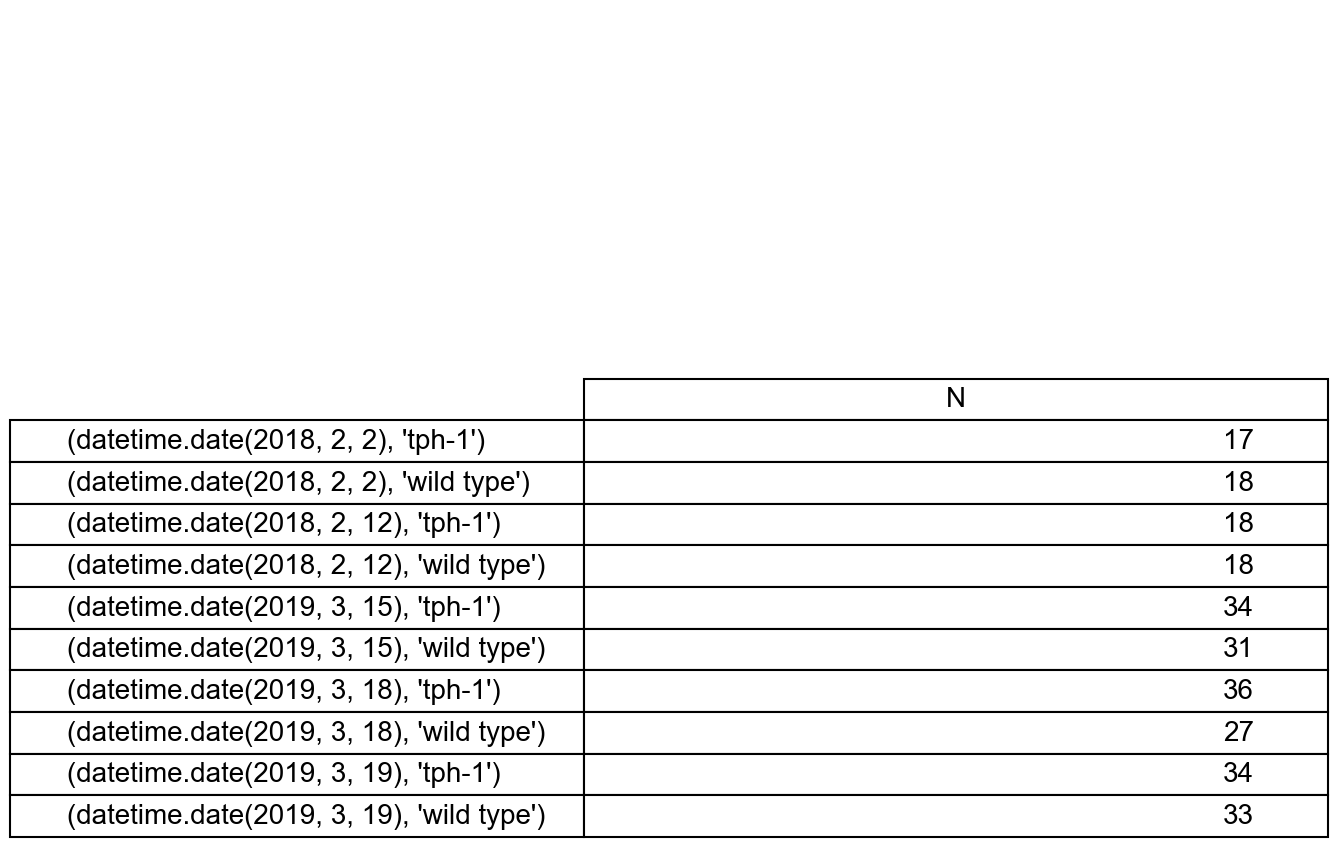

In [19]:
#plot a summary table showing N by date
import matplotlib.pyplot as plt
from pandas.plotting import table 

df_summary = Data_comparison_dfs['missingdata'].rename(columns={"matfilename":"N"}).groupby(["dates","genotype"]).count()['N']

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

ytable = table(ax, df_summary,fontsize=14)
ytable.set_fontsize(20)
ytable.scale(1.5, 2.5)

#prepare for saving:
# draw canvas once
plt.gcf().canvas.draw()
# get bounding box of table
points = ytable.get_window_extent(plt.gcf()._cachedRenderer).get_points()
# add 10 pixel spacing
points[0,:] -= 10; points[1,:] += 10
# get new bounding box in inches
nbbox = mpl.transforms.Bbox.from_extents(points/plt.gcf().dpi)

if saveFigures:
    if len(genNames)<100:
        outpath = os.path.join(subfolder,genNames+'_Data_N_summary'+'_'+datestring+'.png')
    else:
        outpath = os.path.join(subfolder,'Data_N_summary'+'_'+datestring+'.png')
    plt.savefig(outpath,bbox_inches=nbbox,dpi=300)

In [20]:
# Fraction of Animals Leaving, compare methods

#fishers exact test, (bonferroni corrected), make dataframe which can be added to throughout the rest of this notebook
pvals_df = fisher_exact_pvals(Comparisons_df,"containsLLevent",pairs)
pvals_df.to_csv(subfolder+"/fraction_leaving_fishersExactTest_pvalues.csv")


['wild type' 'tph-1']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tph-1: Custom statistical test, P_val:3.194e-03


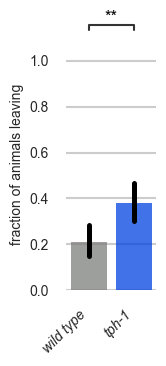

In [21]:
# FRACTION OF ANIMALS LEAVING, stats based on binary encoded 0 = no LL, 1 = at least one LL event per animal
# stats = Fisher's Exact Test
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu, normaltest
import scikit_posthocs as sp
from statsmodels.stats.proportion import proportions_ztest
from statannotations.Annotator import Annotator

rot = 45
plotVar = "containsLLevent"
tmp = pvals_df[['data 0','data 1','pvals_adj']].reset_index(drop=True)

pvalsToShowInOrder = []
for p in pairs:
    print(p)
    pvalsToShowInOrder.append(tmp.where(np.logical_and(tmp['data 0']==p[0], tmp['data 1']==p[1])).dropna()['pvals_adj'].item())


# good seaborn method but can't manually add errorbars
if len(genotypes)==2:
    fig,axs = plt.subplots(1,1,figsize=(2,4))
else:
#     fig,axs = plt.subplots(1,1,figsize=(len(genotypes)*0.6,len(genotypes)*1))
    fig,axs = plt.subplots(1,1,figsize=(len(genotypes)*0.7,len(genotypes)*1+1))
    
g = sns.barplot(data=Comparisons_df,
                x="genotype",
                y="containsLLevent",
                ci=95,
                order=df_containsLL.genotype, 
                palette = genotype_colors,
                errcolor = "black",
                edgecolor="black",
                linewidth = 0,
                saturation = 1, 
                ax = axs)

for bar in g.containers[0]:
    bar.set_alpha(0.75)
g.set_xticklabels(g.get_xticklabels(), rotation=rot,fontstyle='italic',ha='right')
g.set_ylabel("fraction of animals leaving")
g.set_ylim(0,0.6)
g.set_ylim(0,1.1)
g.set_frame_on(False)


g.set_xlabel('')
annotator = Annotator(g, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside',text_offset=0, fontsize=12)
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()



if saveFigures:
    outpath = os.path.join(subfolder,'Fraction_Leaving_ALL_FishersExact'+'_'+datestring+'.pdf')
    plt.savefig(outpath)

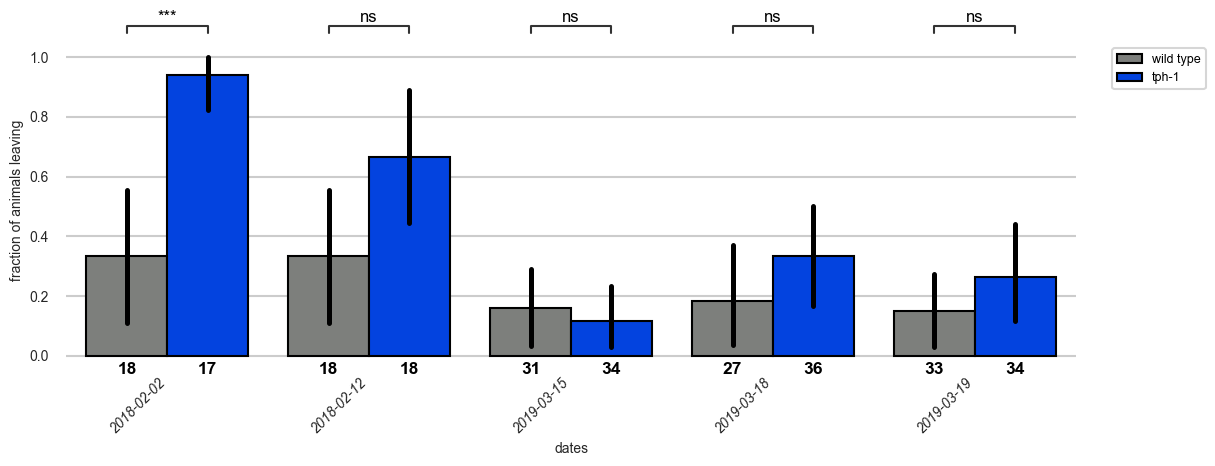

In [23]:
#check Fraction of Animals leaving across days of experiments - what is day to day variability like?
pairslist = list(itertools.combinations(genotypes,2))
dateslist = Comparisons_df['dates'].unique()
mylist = list(((d,s[0]),(d,s[1])) for d in dateslist for s in pairslist)

if len(dateslist)>=4:
    thisfigsize = (len(dateslist)*2.5,5)
else:
    thisfigsize = (5,5)
    
fig,axs = plt.subplots(1,1,figsize=thisfigsize)
g = sns.barplot(data=Comparisons_df,
                x="dates",
                y="containsLLevent",
                hue="genotype",
                order = np.sort(dateslist),
                ci=95,
                palette=genotype_colors,
                errcolor = "black",
                edgecolor="black", 
                saturation = 1, 
                ax = axs)

#add the number of observations per day
nobs = Comparisons_df.groupby(["genotype","dates"])["numLLevent"].agg('count').reindex(genotypes,level=0).values
nobs = [str(x) for x in nobs.tolist()]
pos = range(len(nobs))
for tick, p in zip(pos,g.patches):
    g.text(p.get_x()+(p.get_width()/2),
            -0.06,
            nobs[tick],
            horizontalalignment='center',
            size='x-small',
            color='k',
            weight='semibold')
    
g.set_xticklabels(g.get_xticklabels(), rotation=rot,fontstyle='italic',ha='right')
g.set_ylim([-0.01,1.05])
g.set_ylabel('fraction of animals leaving')
g.set_frame_on(False)


annotator = Annotator(g, 
                      mylist, 
                      data=Comparisons_df, 
                      x="dates",
                      y="containsLLevent",
                      hue="genotype",
                      order = np.sort(dateslist))
annotator.configure(text_format='star', loc='outside',test='Mann-Whitney', verbose=False, fontsize=12) #comparisons_correction="Bonferroni"
annotator.apply_test()
_ = annotator.annotate()

h, l = g.get_legend_handles_labels()
plt.legend(h[0:len(genotypes)],l[0:len(genotypes)],fontsize=9,loc='upper left', bbox_to_anchor=(1.03, 1))

if saveFigures:
    outpath = os.path.join(subfolder,'FractionLeaving_byDate'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/statannotations/

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tph-1: Custom statistical test, P_val:3.194e-03


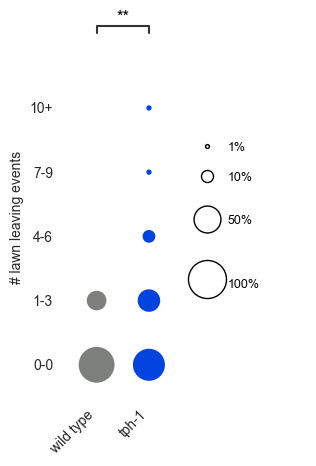

In [26]:
# Assign each animal to a bin of number of lawn leaving events
# bins = np.array([-0.02,  0.5, 5.5  , 10.5  , 15.5  , np.inf  ])#high leaving bins
bins = np.array([-0.02,0.5,3.5,6.5,9.5,np.inf])#normal
# bins = np.array([-0.02,0.5,1.5,2.5,3.5,np.inf])#low range
# bins = np.array([-0.02,0.5,1.5,2.5,np.inf])#tax-4 low range

out,outbins = pd.cut(Comparisons_df["numLLevent"],bins,retbins=True)
# out,outbins = pd.cut(Comparisons_df["numLLevent"],5,retbins=True) #chooses 4 bins to scale to the natural range of bins
# out,outbins = pd.cut(Comparisons_df["numLLevent"],np.round(outbins).astype(int),retbins=True)
Comparisons_df["numLLevent_bin"] = out
#now calculate the fraction of total per genotype that fall in each bin
FracNumLLcountsPerBin = Comparisons_df.groupby(["genotype","numLLevent_bin"]).agg("count")["numLLevent"].unstack().T.apply(lambda x: x/np.sum(x))

fig,axs = plt.subplots(1,1,figsize=(figsize[0]+1,figsize[1]+1))
axs.grid(b=None)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

rad = 750
yscalefactor = 0.75
for i,g in enumerate(genotypes):
    z = FracNumLLcountsPerBin[g].to_numpy()
#     print(z)
    axs.scatter(np.repeat(i,len(outbins)-1), np.arange(len(outbins)-1)*yscalefactor, s=z*rad, c = genotype_colors[i], alpha=1)

axs.scatter(len(genotypes)+0.1,len(outbins)-3.45,s=0.01*rad,c='white',edgecolors='k',lw=1)
axs.text(len(genotypes)+0.5,len(outbins)-3.5,'1%',fontsize=9)
axs.scatter(len(genotypes)+0.1,len(outbins)-3.8,s=0.10*rad,c='white',edgecolors='k',lw=1)
axs.text(len(genotypes)+0.5,len(outbins)-3.85,'10%',fontsize=9)
axs.scatter(len(genotypes)+0.1,len(outbins)-4.3,s=0.50*rad,c='white',edgecolors='k',lw=1)
axs.text(len(genotypes)+0.5,len(outbins)-4.35,'50%',fontsize=9)
axs.scatter(len(genotypes)+0.1,len(outbins)-5,s=1*rad,c='white',edgecolors='k',lw=1)
axs.text(len(genotypes)+0.5,len(outbins)-5.1,'100%',fontsize=9)

axs.set_xlim(-0.5,len(genotypes)+2)
axs.set_ylim(-0.3,(len(outbins)-1)*yscalefactor)
axs.set_yticks(np.arange(len(outbins)-1)*yscalefactor)
leftColumn = np.concatenate(([0],outbins[1:-1]+1)).reshape(-1,1)
rightColumn = outbins[1:].reshape(-1,1)
together = np.hstack((leftColumn,rightColumn)).astype(int)
yTickLabels = [str(t[0])+'-'+str(t[1]) for t in together]
yTickLabels[-1] = str(leftColumn[-1][0].astype(int))+'+'
axs.set_yticklabels(yTickLabels,fontsize=10)
axs.set_ylabel('# lawn leaving events')
axs.set_xticks(np.arange(len(genotypes)))
axs.set_xticklabels(genotypes,rotation=45,ha='right')


annotator = Annotator(axs, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside', fontsize=12)
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()

if saveFigures:
    outpath = os.path.join(subfolder,'numLawnLeavingEvents_BubblePlot_ALL'+'_'+datestring+'.pdf')
    plt.savefig(outpath)

In [27]:
#save pvalues
pvals_dict = dict()
for i,p in enumerate(pairs):
    pvals_dict[p[0]+', '+p[1]] = pvalsToShowInOrder[i]
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pvalsToShowInOrder])
if len(genotypes)==2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_MannWhitneyU"+"_pvalues.csv")
elif len(genotypes)>2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_postHocDunn"+"_pvalues.csv")
else:
    raise Exception("you need at least two genotypes to compare.")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tph-1: Custom statistical test, P_val:2.624e-30


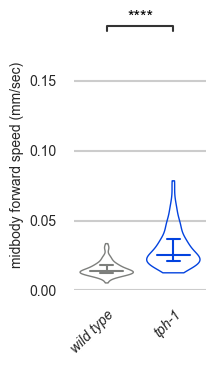

In [28]:
# MIDBODY FORWARD SPEED (Kruskal-Wallis with Dunn's posthoc)
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp

rot = 45
plotVar = 'midbody forward speed'

###
if len(genotypes)==2:
    #define samples
    group1 = Comparisons_df[Comparisons_df['genotype']==genotypes[0]]
    group2 = Comparisons_df[Comparisons_df['genotype']==genotypes[1]]
    #perform independent two sample Mann-Whitney
    _, pval_adj = mannwhitneyu(group1[plotVar], group2[plotVar])
    pvalsToShowInOrder = [pval_adj]
elif len(genotypes)>2:
    pval_adj = sp.posthoc_dunn(Comparisons_df, val_col = plotVar, group_col = "genotype", p_adjust = 'bonferroni')
    pvalsToShowInOrder = []
    for p in pairs:
        pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])
else:
    raise Exception("you need at least two genotypes to compare.")
###


fig,axs = plt.subplots(1,1,figsize=figsize)
df_points = Comparisons_df

g = sns.violinplot(data=Comparisons_df,x="genotype",y=plotVar,order=df_containsLL.genotype,ax=axs,palette = genotype_colors, saturation = 1,inner=None,linewidth=1,cut=0,scale='width',zorder=0)
for violin in g.collections:
    violin.set_edgecolor(violin.get_facecolor())
    violin.set_facecolor('None')

#DIY custom boxplot
#make the medians pop, plot the quartiles a bit narrower
m_width = 0.5
q_width = 0.2
medians = Comparisons_df.groupby("genotype")[plotVar].median().reindex(genotypes)
lower_q = Comparisons_df.groupby("genotype")[plotVar].quantile(0.25).reindex(genotypes)
upper_q = Comparisons_df.groupby("genotype")[plotVar].quantile(0.75).reindex(genotypes)
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-q_width/2, xtick+q_width/2], [lower_q[i], lower_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick-q_width/2, xtick+q_width/2], [upper_q[i], upper_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians[i], medians[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick, xtick], [lower_q[i], upper_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)

g.set_xticklabels(g.get_xticklabels(), rotation=rot,rotation_mode='anchor',fontstyle='italic',ha='right')
#change this to set the maximum y value
g.set_ylim([-0.00,0.18]) #inedible food
# g.set_ylim([-0.00,0.08]) #normal range
g.set_ylabel('midbody forward speed (mm/sec)')
g.set_frame_on(False)
plt.locator_params(nbins=6)

for patch in g.artists:
    rc, gc, bc, a = patch.get_facecolor()
    patch.set_facecolor((rc, gc, bc, .6))

g.set_xlabel('')
annotator = Annotator(g, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside', fontsize=12)
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()

if saveFigures:
    outpath = os.path.join(subfolder,'MidbodyForwardSpeed'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')


In [29]:
#save pvalues
pvals_dict = dict()
for i,p in enumerate(pairs):
    pvals_dict[p[0]+', '+p[1]] = pvalsToShowInOrder[i]
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pvalsToShowInOrder])
if len(genotypes)==2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_MannWhitneyU"+"_pvalues.csv")
elif len(genotypes)>2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_postHocDunn"+"_pvalues.csv")
else:
    raise Exception("you need at least two genotypes to compare.")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tph-1: Custom statistical test, P_val:2.577e-39


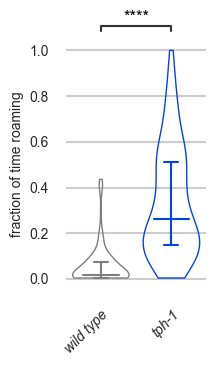

In [30]:
#FRACTION ROAMING - Logit transformed data followed by One Way ANOVA, posthoc Tukey
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu, normaltest, ttest_ind
from scipy.special import logit
from statannotations.Annotator import Annotator

plotVar = 'fraction roaming'
pVar = 'logit_frac_roam'
Comparisons_df[pVar] = logit(linscaleData_minmax(Comparisons_df[plotVar],1/240,239/240)) #very important addition, may change a lot! - data needs to be scaled to exclude 0 and 1 before Logit!
if len(genotypes)==2:
    #define samples
    group1 = Comparisons_df[Comparisons_df['genotype']==genotypes[0]]
    group2 = Comparisons_df[Comparisons_df['genotype']==genotypes[1]]
    #perform independent two sample t-test
    _, pval_adj = ttest_ind(group1[pVar], group2[pVar])
    pvalsToShowInOrder = [pval_adj]
elif len(genotypes)>2:
    pval_adj = sp.posthoc_tukey(Comparisons_df, val_col = pVar, group_col = "genotype")
    pvalsToShowInOrder = []
    for p in pairs:
        pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])
else:
    raise Exception("you need at least two genotypes to compare.")




fig,axs = plt.subplots(1,1,figsize=figsize)
    
g = sns.violinplot(data=Comparisons_df,x="genotype",y=plotVar,order=df_containsLL.genotype,ax=axs,palette = genotype_colors, saturation = 1,inner=None,linewidth=1,cut=0,scale='width',zorder=0)
for violin in g.collections:
    violin.set_edgecolor(violin.get_facecolor())
    violin.set_facecolor('None')

#DIY custom boxplot
#make the medians pop, plot the quartiles a bit narrower
m_width = 0.5
q_width = 0.2
medians = Comparisons_df.groupby("genotype")[plotVar].median().reindex(genotypes)
lower_q = Comparisons_df.groupby("genotype")[plotVar].quantile(0.25).reindex(genotypes)
upper_q = Comparisons_df.groupby("genotype")[plotVar].quantile(0.75).reindex(genotypes)
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-q_width/2, xtick+q_width/2], [lower_q[i], lower_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick-q_width/2, xtick+q_width/2], [upper_q[i], upper_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians[i], medians[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick, xtick], [lower_q[i], upper_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)

g.set_xticklabels(g.get_xticklabels(), rotation=rot,rotation_mode='anchor',fontstyle='italic',ha='right')
g.set_yticks(np.arange(0,1.1,0.2))
g.set_ylim([-0.05,1.05])
g.set_ylabel('fraction of time roaming')
g.set_frame_on(False)
# plt.locator_params(nbins=6)

g.set_xlabel('')
annotator = Annotator(g, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside', fontsize=12)
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()

if saveFigures:
    outpath = os.path.join(subfolder,'FractionRoaming'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')


In [31]:
#save pvalues
pvals_dict = dict()
for i,p in enumerate(pairs):
    pvals_dict[p[0]+', '+p[1]] = pvalsToShowInOrder[i]
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pvalsToShowInOrder])

if len(genotypes)==2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_Logit_ttest"+"_pvalues.csv")
elif len(genotypes)>2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_Logit_1wayANOVA"+"_pvalues.csv")
else:
    raise Exception("you need at least two genotypes to compare.")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

tph-1_False vs. tph-1_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:5.914e-11 U_stat=7.220e+02
wild type_False vs. wild type_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.500e-03 U_stat=7.770e+02
wild type_False vs. tph-1_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.677e-20 U_stat=9.280e+02
wild type_True vs. tph-1_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.904e-11 U_stat=5.900e+01


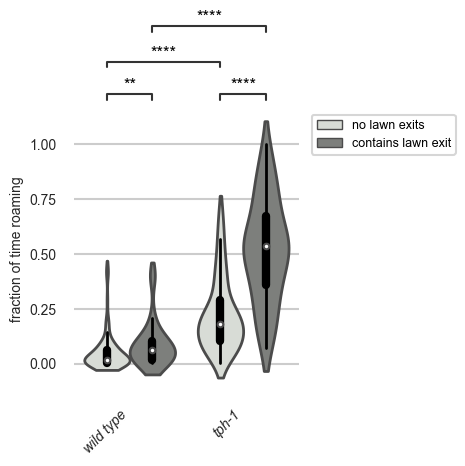

In [32]:
#Compare the fraction of time roaming for non-leavers and leavers

fig,axs = plt.subplots(1,1,figsize=(len(genotypes)*2.5,len(genotypes)*2.5))
# g = sns.swarmplot(data=df_points,x="genotype",y='fraction roaming',hue='containsLLevent',order=df_containsLL.genotype,dodge=True, linewidth=0.5,edgecolor='gray',size=2,ax = axs)
g = sns.violinplot(data=Comparisons_df,x="genotype",y='fraction roaming',hue='containsLLevent',order=df_containsLL.genotype,ax=axs,saturation = 1,cut=True,scale='width')
g.set_xticklabels(g.get_xticklabels(), rotation=rot,fontstyle='italic',ha='right')

plt.setp(g.artists, edgecolor = 'k')
plt.setp(g.lines, color='k')
# g.set_ylim([-0.01,1.05])
g.set_ylabel('fraction of time roaming')
g.set_frame_on(False)
plt.locator_params(nbins=6)

for patch in g.artists:
    rc, gc, bc, a = patch.get_facecolor()
    patch.set_facecolor((rc, gc, bc, .6))

g.set_xlabel('')

pairslist = list(itertools.combinations(genotypes,2))
mylist = [((g,False),(g,True)) for g in genotypes]
mylist = mylist+(list(((s[0], False),(s[1],False)) for s in pairslist))
mylist = mylist+(list(((s[0], True),(s[1],True)) for s in pairslist))

annotator = Annotator(g, 
                      mylist, 
                      data=Comparisons_df, 
                      x="genotype",
                      y='fraction roaming',
                      hue='containsLLevent',
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside',test='Mann-Whitney', comparisons_correction="Bonferroni", verbose=2, fontsize=12)
annotator.apply_test()
_ = annotator.annotate()

h, l = g.get_legend_handles_labels()
plt.legend(h[0:2],['no lawn exits','contains lawn exit'],fontsize=9,loc='upper left', bbox_to_anchor=(1.03, 1))

if saveFigures:
    outpath = os.path.join(subfolder,'FractionRoaming_Leavers_vs_NonLeavers'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2018-02-12_wild type vs. 2018-02-12_tph-1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.644e-03 U_stat=6.200e+01
2018-02-02_wild type vs. 2018-02-02_tph-1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.846e-06 U_stat=8.000e+00
2019-03-15_wild type vs. 2019-03-15_tph-1: Mann-Whitney-Wilcoxon test two-sided, P_val:4.137e-10 U_stat=5.450e+01
2019-03-19_wild type vs. 2019-03-19_tph-1: Mann-Whitney-Wilcoxon test two-sided, P_val:4.052e-11 U_stat=3.650e+01
2019-03-18_wild type vs. 2019-03-18_tph-1: Mann-Whitney-Wilcoxon test two-sided, P_val:9.050e-11 U_stat=1.950e+01


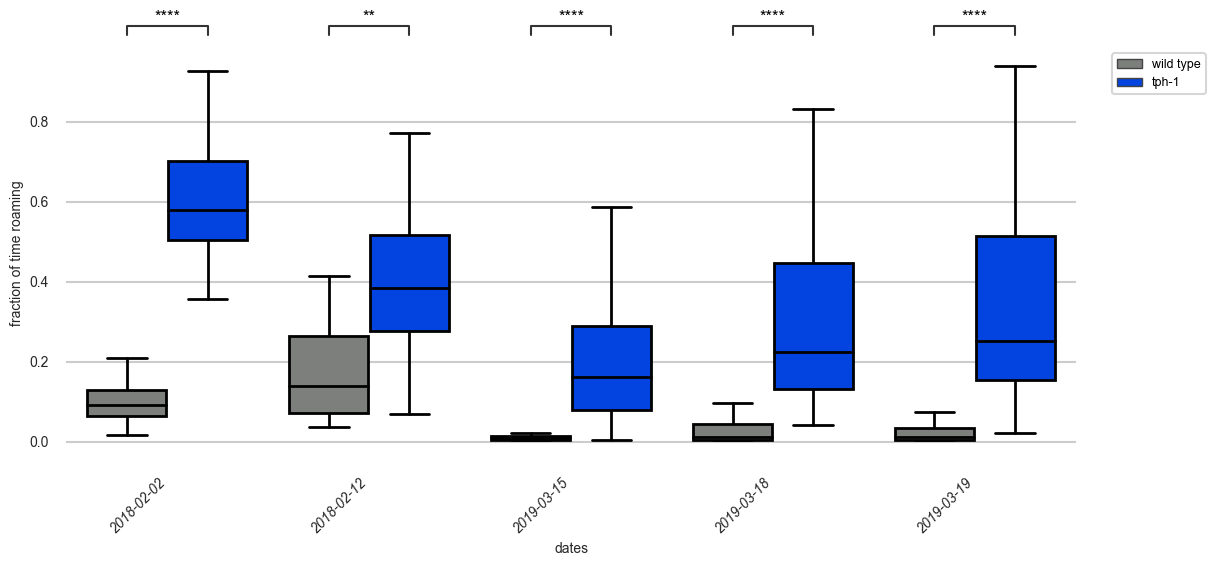

In [33]:
#check Fraction of time Roaming across days of experiments - what is day to day variability like?
pairslist = list(itertools.combinations(genotypes,2))
dateslist = Comparisons_df['dates'].unique()
mylist = list(((d,s[0]),(d,s[1])) for d in dateslist for s in pairslist)

if len(dateslist)>=4:
    thisfigsize = (len(dateslist)*2.5,6)
else:
    thisfigsize = (5,5)
    
fig,axs = plt.subplots(1,1,figsize=thisfigsize)
# g = sns.violinplot(data=Comparisons_df,
#                 x="dates",
#                 y="fraction roaming",
#                 hue="genotype",
#                 order = np.sort(dateslist),
#                 palette=genotype_colors,
#                 saturation = 1, 
#                 ax = axs,
#                 cut=True)
g = sns.boxplot(data=Comparisons_df,
                x="dates",
                y="fraction roaming",
                hue="genotype",
                order = np.sort(dateslist),
                ax=axs,
                palette=genotype_colors,
                saturation = 1, 
                showfliers=False,
                linewidth=2,
                boxprops={'zorder': 2})
plt.setp(g.artists, edgecolor = 'k')
plt.setp(g.lines, color='k')
plt.setp(g.collections, alpha=.75)

g.set_xticklabels(g.get_xticklabels(), rotation=rot,fontstyle='italic',ha='right')
# g.set_ylim([-0.01,0.75])
g.set_ylabel('fraction of time roaming')
g.set_frame_on(False)

annotator = Annotator(g, 
                      mylist, 
                      data=Comparisons_df, 
                      x="dates",
                      y="fraction roaming",
                      hue="genotype",
                      order = np.sort(dateslist))
annotator.configure(text_format='star', loc='outside',test='Mann-Whitney', verbose=2, fontsize=12)
annotator.apply_test()
_ = annotator.annotate()

h, l = g.get_legend_handles_labels()
plt.legend(h[0:len(genotypes)],l[0:len(genotypes)],fontsize=9,loc='upper left', bbox_to_anchor=(1.03, 1))

if saveFigures:
    outpath = os.path.join(subfolder,'FractionRoaming_byDate'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tph-1: Custom statistical test, P_val:1.844e-26


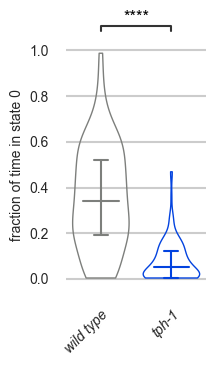

In [34]:
#FRACTION state 0 Logit-transformed One Way ANOVA
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
from scipy.special import logit

plotVar = 'fraction state 0'
pVar = 'logit_frac_0'
Comparisons_df[pVar] = logit(linscaleData_minmax(Comparisons_df[plotVar],1/240,239/240))
###
if len(genotypes)==2:
    #define samples
    group1 = Comparisons_df[Comparisons_df['genotype']==genotypes[0]]
    group2 = Comparisons_df[Comparisons_df['genotype']==genotypes[1]]
    #perform independent two sample t-test
    _, pval_adj = ttest_ind(group1[pVar], group2[pVar])
    pvalsToShowInOrder = [pval_adj]
elif len(genotypes)>2:
    pval_adj = sp.posthoc_tukey(Comparisons_df, val_col = pVar, group_col = "genotype")
    pvalsToShowInOrder = []
    for p in pairs:
        pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])
else:
    raise Exception("you need at least two genotypes to compare.")
###


fig,axs = plt.subplots(1,1,figsize=figsize)
df_points = Comparisons_df

g = sns.violinplot(data=Comparisons_df,x="genotype",y=plotVar,order=df_containsLL.genotype,ax=axs,palette = genotype_colors, saturation = 1,inner=None,linewidth=1,cut=0,scale='width',zorder=0)
for violin in g.collections:
    violin.set_edgecolor(violin.get_facecolor())
    violin.set_facecolor('None')

#DIY custom boxplot
#make the medians pop, plot the quartiles a bit narrower
m_width = 0.5
q_width = 0.2
medians = Comparisons_df.groupby("genotype")[plotVar].median().reindex(genotypes)
lower_q = Comparisons_df.groupby("genotype")[plotVar].quantile(0.25).reindex(genotypes)
upper_q = Comparisons_df.groupby("genotype")[plotVar].quantile(0.75).reindex(genotypes)
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-q_width/2, xtick+q_width/2], [lower_q[i], lower_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick-q_width/2, xtick+q_width/2], [upper_q[i], upper_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians[i], medians[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick, xtick], [lower_q[i], upper_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)

g.set_xticklabels(g.get_xticklabels(), rotation=rot,rotation_mode='anchor',fontstyle='italic',ha='right')

# plt.setp(g.artists, edgecolor = 'k')
# plt.setp(g.lines, color='k')
# plt.setp(g.collections, alpha=.75)

# g.set_ylim([-0.05,1.05])
g.set_ylim([-0.05,1.05])
g.set_ylabel('fraction of time in state 0')
g.set_frame_on(False)
plt.locator_params(nbins=6)

for patch in g.artists:
    rc, gc, bc, a = patch.get_facecolor()
    patch.set_facecolor((rc, gc, bc, .6))
    
g.set_xlabel('')
annotator = Annotator(g, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside', fontsize=12)
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()

if saveFigures:
    outpath = os.path.join(subfolder,'Fractionstate0'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')


In [35]:
#save pvalues
pvals_dict = dict()
for i,p in enumerate(pairs):
    pvals_dict[p[0]+', '+p[1]] = pvalsToShowInOrder[i]
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pvalsToShowInOrder])

if len(genotypes)==2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_Logit_ttest"+"_pvalues.csv")
elif len(genotypes)>2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_Logit_1wayANOVA"+"_pvalues.csv")
else:
    raise Exception("you need at least two genotypes to compare.")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tph-1: Custom statistical test, P_val:1.507e-06


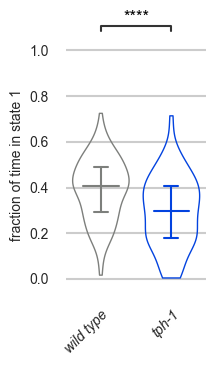

In [36]:
#FRACTION state 1 Logit transformed- One Way ANOVA
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
from scipy.special import logit

plotVar = 'fraction state 1'
pVar = 'logit_frac_1'
Comparisons_df[pVar] = logit(linscaleData_minmax(Comparisons_df[plotVar],1/240,239/240))
###
if len(genotypes)==2:
    #define samples
    group1 = Comparisons_df[Comparisons_df['genotype']==genotypes[0]]
    group2 = Comparisons_df[Comparisons_df['genotype']==genotypes[1]]
    #perform independent two sample t-test
    _, pval_adj = ttest_ind(group1[pVar], group2[pVar])
    pvalsToShowInOrder = [pval_adj]
elif len(genotypes)>2:
    pval_adj = sp.posthoc_tukey(Comparisons_df, val_col = pVar, group_col = "genotype")
    pvalsToShowInOrder = []
    for p in pairs:
        pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])
else:
    raise Exception("you need at least two genotypes to compare.")
###


fig,axs = plt.subplots(1,1,figsize=figsize)
df_points = Comparisons_df

# if sample_size != None:
#     df_points = Comparisons_df.groupby("genotype").apply(lambda x: x.sample(np.minimum(len(x),sample_size),replace=False,random_state=0)).reset_index(drop=True)
# else:
#     df_points = Comparisons_df

# g = sns.stripplot(data=df_points,x="genotype",y=plotVar,order=df_containsLL.genotype,jitter=True,dodge=True, linewidth=0.5,palette = genotype_colors, edgecolor='gray',size=2,ax = axs)
# g = sns.swarmplot(data=df_points,x="genotype",y=plotVar,order=df_containsLL.genotype,dodge=True, linewidth=0.5,palette = genotype_colors, edgecolor='gray',size=1.5,ax = axs)
# g = sns.violinplot(data=Comparisons_df,x="genotype",y=plotVar,order=df_containsLL.genotype,ax=axs,palette = genotype_colors, saturation = 1,inner=None,linewidth=0,cut=True,scale='width')
# g = sns.boxplot(data=Comparisons_df,x="genotype",y=plotVar,order=df_containsLL.genotype,ax=g,palette = genotype_colors,saturation = 1,showfliers=False,width=0.1,linewidth=1,boxprops={'zorder': 2})
# g.set_xticklabels(g.get_xticklabels(), rotation=rot,fontstyle='italic',ha='right')
# plt.setp(g.artists, edgecolor = 'k')
# plt.setp(g.lines, color='k')
# plt.setp(g.collections, alpha=.75)
# for patch in g.artists:
#     rc, gc, bc, a = patch.get_facecolor()
#     patch.set_facecolor((rc, gc, bc, .6))

g = sns.violinplot(data=Comparisons_df,x="genotype",y=plotVar,order=df_containsLL.genotype,ax=axs,palette = genotype_colors, saturation = 1,inner=None,linewidth=1,cut=0,scale='width',zorder=0)
for violin in g.collections:
    violin.set_edgecolor(violin.get_facecolor())
    violin.set_facecolor('None')

#DIY custom boxplot
#make the medians pop, plot the quartiles a bit narrower
m_width = 0.5
q_width = 0.2
medians = Comparisons_df.groupby("genotype")[plotVar].median().reindex(genotypes)
lower_q = Comparisons_df.groupby("genotype")[plotVar].quantile(0.25).reindex(genotypes)
upper_q = Comparisons_df.groupby("genotype")[plotVar].quantile(0.75).reindex(genotypes)
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-q_width/2, xtick+q_width/2], [lower_q[i], lower_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick-q_width/2, xtick+q_width/2], [upper_q[i], upper_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians[i], medians[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick, xtick], [lower_q[i], upper_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)

g.set_xticklabels(g.get_xticklabels(), rotation=rot,rotation_mode='anchor',fontstyle='italic',ha='right')

g.set_ylim([-0.05,1.05])
# g.set_ylim([-0.01,0.4])
g.set_ylabel('fraction of time in state 1')
g.set_frame_on(False)
plt.locator_params(nbins=6)


    
g.set_xlabel('')
annotator = Annotator(g, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside', fontsize=12)
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()

if saveFigures:
    outpath = os.path.join(subfolder,'Fractionstate1'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')


In [37]:
#save pvalues
pvals_dict = dict()
for i,p in enumerate(pairs):
    pvals_dict[p[0]+', '+p[1]] = pvalsToShowInOrder[i]
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pvalsToShowInOrder])

if len(genotypes)==2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_Logit_ttest"+"_pvalues.csv")
elif len(genotypes)>2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_Logit_1wayANOVA"+"_pvalues.csv")
else:
    raise Exception("you need at least two genotypes to compare.")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tph-1: Custom statistical test, P_val:7.507e-18


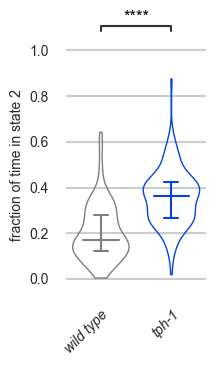

In [38]:
#FRACTION state 2 Logit transformed- One Way ANOVA
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
from scipy.special import logit

plotVar = 'fraction state 2'
pVar = 'logit_frac_2'
Comparisons_df[pVar] = logit(linscaleData_minmax(Comparisons_df[plotVar],1/240,239/240))
###
if len(genotypes)==2:
    #define samples
    group1 = Comparisons_df[Comparisons_df['genotype']==genotypes[0]]
    group2 = Comparisons_df[Comparisons_df['genotype']==genotypes[1]]
    #perform independent two sample t-test
    _, pval_adj = ttest_ind(group1[pVar], group2[pVar])
    pvalsToShowInOrder = [pval_adj]
elif len(genotypes)>2:
    pval_adj = sp.posthoc_tukey(Comparisons_df, val_col = pVar, group_col = "genotype")
    pvalsToShowInOrder = []
    for p in pairs:
        pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])
else:
    raise Exception("you need at least two genotypes to compare.")
###

fig,axs = plt.subplots(1,1,figsize=figsize)
df_points = Comparisons_df

g = sns.violinplot(data=Comparisons_df,x="genotype",y=plotVar,order=df_containsLL.genotype,ax=axs,palette = genotype_colors, saturation = 1,inner=None,linewidth=1,cut=0,scale='width',zorder=0)
for violin in g.collections:
    violin.set_edgecolor(violin.get_facecolor())
    violin.set_facecolor('None')

#DIY custom boxplot
#make the medians pop, plot the quartiles a bit narrower
m_width = 0.5
q_width = 0.2
medians = Comparisons_df.groupby("genotype")[plotVar].median().reindex(genotypes)
lower_q = Comparisons_df.groupby("genotype")[plotVar].quantile(0.25).reindex(genotypes)
upper_q = Comparisons_df.groupby("genotype")[plotVar].quantile(0.75).reindex(genotypes)
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-q_width/2, xtick+q_width/2], [lower_q[i], lower_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick-q_width/2, xtick+q_width/2], [upper_q[i], upper_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians[i], medians[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick, xtick], [lower_q[i], upper_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)

g.set_xticklabels(g.get_xticklabels(), rotation=rot,rotation_mode='anchor',fontstyle='italic',ha='right')

g.set_ylim([-0.05,1.05])
# g.set_ylim([-0.01,0.4])
g.set_ylabel('fraction of time in state 2')
g.set_frame_on(False)
plt.locator_params(nbins=6)

g.set_xlabel('')
annotator = Annotator(g, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside', fontsize=12)
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()

if saveFigures:
    outpath = os.path.join(subfolder,'Fractionstate2'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')


In [39]:
#save pvalues
pvals_dict = dict()
for i,p in enumerate(pairs):
    pvals_dict[p[0]+', '+p[1]] = pvalsToShowInOrder[i]
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pvalsToShowInOrder])

if len(genotypes)==2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_Logit_ttest"+"_pvalues.csv")
elif len(genotypes)>2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_Logit_1wayANOVA"+"_pvalues.csv")
else:
    raise Exception("you need at least two genotypes to compare.")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tph-1: Custom statistical test, P_val:9.534e-29


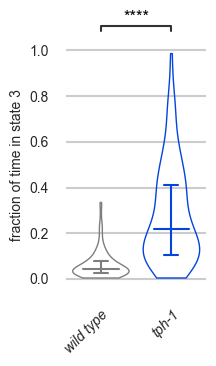

In [40]:
#FRACTION State 3 Logit transformed- One Way ANOVA
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
from scipy.special import logit

plotVar = 'fraction state 3'
pVar = 'logit_frac_3'
Comparisons_df[pVar] = logit(linscaleData_minmax(Comparisons_df[plotVar],1/240,239/240))
###
if len(genotypes)==2:
    #define samples
    group1 = Comparisons_df[Comparisons_df['genotype']==genotypes[0]]
    group2 = Comparisons_df[Comparisons_df['genotype']==genotypes[1]]
    #perform independent two sample t-test
    _, pval_adj = ttest_ind(group1[pVar], group2[pVar])
    pvalsToShowInOrder = [pval_adj]
elif len(genotypes)>2:
    pval_adj = sp.posthoc_tukey(Comparisons_df, val_col = pVar, group_col = "genotype")
    pvalsToShowInOrder = []
    for p in pairs:
        pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])
else:
    raise Exception("you need at least two genotypes to compare.")
###

fig,axs = plt.subplots(1,1,figsize=figsize)
df_points = Comparisons_df

g = sns.violinplot(data=Comparisons_df,x="genotype",y=plotVar,order=df_containsLL.genotype,ax=axs,palette = genotype_colors, saturation = 1,inner=None,linewidth=1,cut=0,scale='width',zorder=0)
for violin in g.collections:
    violin.set_edgecolor(violin.get_facecolor())
    violin.set_facecolor('None')

#DIY custom boxplot
#make the medians pop, plot the quartiles a bit narrower
m_width = 0.5
q_width = 0.2
medians = Comparisons_df.groupby("genotype")[plotVar].median().reindex(genotypes)
lower_q = Comparisons_df.groupby("genotype")[plotVar].quantile(0.25).reindex(genotypes)
upper_q = Comparisons_df.groupby("genotype")[plotVar].quantile(0.75).reindex(genotypes)
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-q_width/2, xtick+q_width/2], [lower_q[i], lower_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick-q_width/2, xtick+q_width/2], [upper_q[i], upper_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians[i], medians[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)
    g.plot([xtick, xtick], [lower_q[i], upper_q[i]], color= genotype_colors[i], linestyle='-', linewidth=1.5,zorder=3)

g.set_xticklabels(g.get_xticklabels(), rotation=rot,rotation_mode='anchor',fontstyle='italic',ha='right')

# g.set_ylim([-0.01,0.5])
g.set_ylim([-0.05,1.05])

g.set_ylabel('fraction of time in state 3')
g.set_frame_on(False)
plt.locator_params(nbins=6)

    
g.set_xlabel('')
annotator = Annotator(g, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside', fontsize=12)
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()

if saveFigures:
    outpath = os.path.join(subfolder,'FractionState3'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')


In [41]:
#save pvalues
pvals_dict = dict()
for i,p in enumerate(pairs):
    pvals_dict[p[0]+', '+p[1]] = pvalsToShowInOrder[i]
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pvalsToShowInOrder])

if len(genotypes)==2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_Logit_ttest"+"_pvalues.csv")
elif len(genotypes)>2:
    pval_df.to_csv(subfolder+"/"+plotVar+"_Logit_1wayANOVA"+"_pvalues.csv")
else:
    raise Exception("you need at least two genotypes to compare.")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2018-02-12_wild type vs. 2018-02-12_tph-1: Mann-Whitney-Wilcoxon test two-sided, P_val:4.467e-05 U_stat=3.250e+01
2018-02-02_wild type vs. 2018-02-02_tph-1: Mann-Whitney-Wilcoxon test two-sided, P_val:6.612e-06 U_stat=1.600e+01
2019-03-15_wild type vs. 2019-03-15_tph-1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.783e-09 U_stat=6.850e+01
2019-03-19_wild type vs. 2019-03-19_tph-1: Mann-Whitney-Wilcoxon test two-sided, P_val:4.992e-08 U_stat=1.260e+02
2019-03-18_wild type vs. 2019-03-18_tph-1: Mann-Whitney-Wilcoxon test two-sided, P_val:6.389e-09 U_stat=6.750e+01


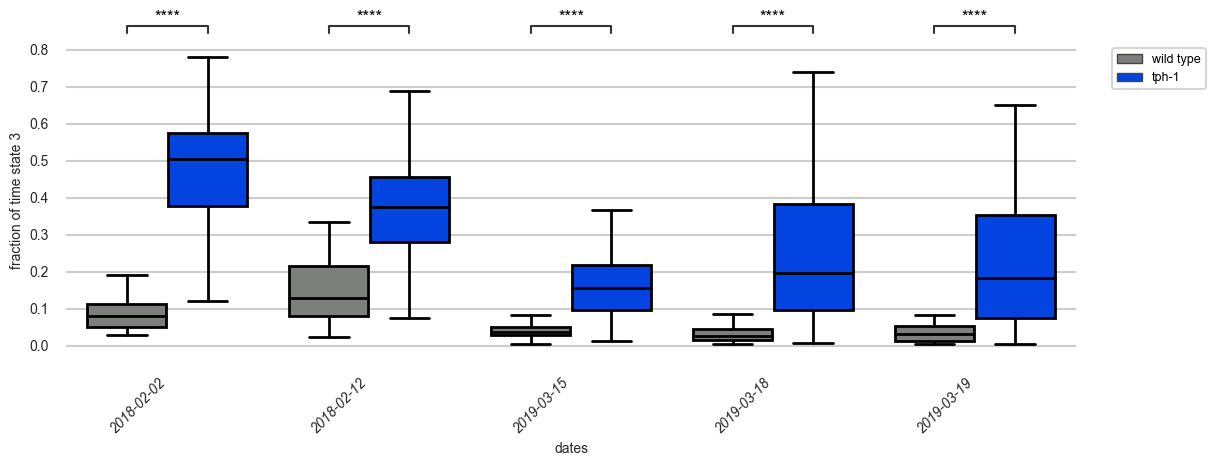

In [42]:
#check Fraction of time State 3 across days of experiments - what is day to day variability like?
pairslist = list(itertools.combinations(genotypes,2))
dateslist = Comparisons_df['dates'].unique()
mylist = list(((d,s[0]),(d,s[1])) for d in dateslist for s in pairslist)

if len(dateslist)>=4:
    thisfigsize = (len(dateslist)*2.5,5)
else:
    thisfigsize = (5,5)
    
fig,axs = plt.subplots(1,1,figsize=thisfigsize)
# g = sns.violinplot(data=Comparisons_df,
#                 x="dates",
#                 y="fraction state 3",
#                 hue="genotype",
#                 order = np.sort(dateslist),
#                 palette=genotype_colors,
#                 saturation = 1, 
#                 ax = axs,
#                 cut=True)

g = sns.boxplot(data=Comparisons_df,
                x="dates",
                y="fraction state 3",
                hue="genotype",
                order = np.sort(dateslist),
                ax=axs,
                palette=genotype_colors,
                saturation = 1, 
                showfliers=False,
                linewidth=2,
                boxprops={'zorder': 2})

g.set_xticklabels(g.get_xticklabels(), rotation=rot,fontstyle='italic',ha='right')

plt.setp(g.artists, edgecolor = 'k')
plt.setp(g.lines, color='k')
plt.setp(g.collections, alpha=.75)

# g.set_ylim([-0.01,0.4])
g.set_ylabel('fraction of time state 3')
g.set_frame_on(False)

annotator = Annotator(g, 
                      mylist, 
                      data=Comparisons_df, 
                      x="dates",
                      y="fraction state 3",
                      hue="genotype",
                      order = np.sort(dateslist))
annotator.configure(text_format='star', loc='outside',test='Mann-Whitney', verbose=2, fontsize=12) #comparisons_correction="Bonferroni"
annotator.apply_test()
_ = annotator.annotate()

h, l = g.get_legend_handles_labels()
plt.legend(h[0:len(genotypes)],l[0:len(genotypes)],fontsize=9,loc='upper left', bbox_to_anchor=(1.03, 1))

if saveFigures:
    outpath = os.path.join(subfolder,'FractionState3_byDate'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')


In [43]:
#define figure size for comparison plot

aligned_solo_figSize = figsize=(6,4) #default
aligned_overlay_figSize = figsize=(4,4) #default (4,4), change to 5,4 for long genotype names


['wild type' 'tph-1'],before: 1.2058125959458905e-11,****; after: 0.0007628916726379584,***


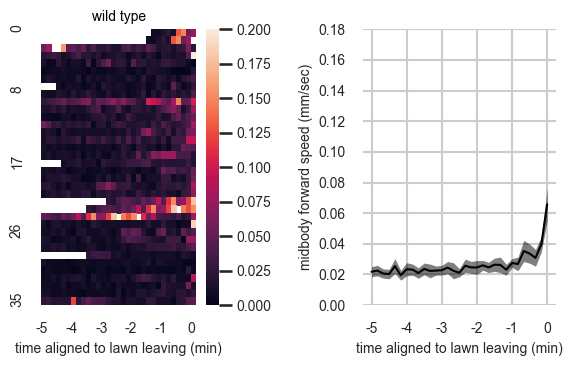

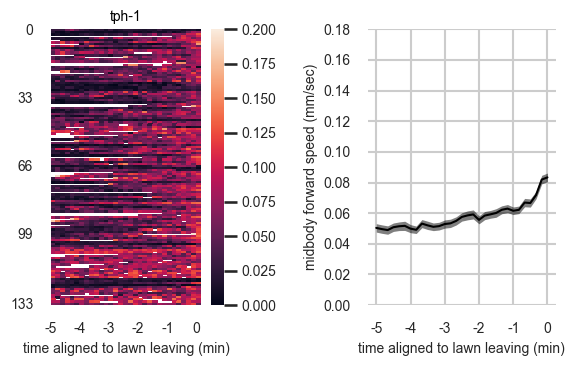

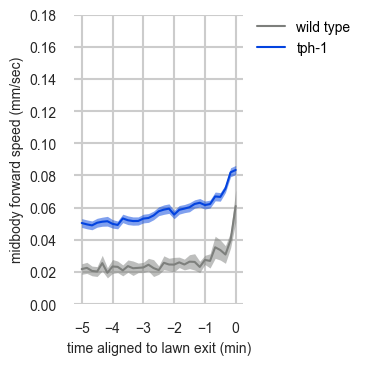

In [44]:
#MIDBODY FORWARD SPEED ALIGNED TO LAWN LEAVING
import matplotlib.pyplot as plt
framesPerMin = 6

#align data to HPREV and LL
numMins = 5
binTimeBefore = (numMins*framesPerMin) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = 1#((numMins)*framesPerMin) # X minutes after
missingFracThresh = 0.6
Data = list(Data_subs.items())[0][1]
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],Data['bin_LawnExit_mostRecent']>0,binTimeBefore,binTimeAfter,dtype=float)
xticksToPlot = np.hstack((binTimeLine[0:-1:framesPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*framesPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / framesPerMin).astype(int)
timeLine2 = binTimeLine / framesPerMin
xticksToPlot2 = np.round(np.linspace(timeLine2[0], timeLine2[-1], len(xticksToPlot)))

minSpeed_c = 0.0
maxSpeed_c = 0.15
minSpeed_v = 0.0
maxSpeed_v = 0.12

#for inedible food / npr-1
minSpeed_c = 0.0
maxSpeed_c = 0.20
minSpeed_v = 0.0
maxSpeed_v = 0.18

for d_key, d_val in Data_subs.items():
    binLawnExit = d_val['bin_LawnExit_mostRecent']
    if np.sum(np.sum(binLawnExit))<2:
        print("no LE: "+d_key)
        continue
    bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(d_val['bin_Midbody_fspeed'],~d_val['InLawnRunMask'],d_val['bin_LawnExit_mostRecent']>0,binTimeBefore,binTimeAfter,dtype=float)
    fig,ax = plt.subplots(1,2,figsize=aligned_solo_figSize)
    
    ax = plotAligned_masked(ax, 
                            bin_Midbody_fspeed_LLaligned, 
                            binTimeLine, 
                            binTimeBefore, 
                            minSpeed_c, 
                            maxSpeed_c, 
                            framesPerMin, 
                            'midbody forward speed (mm/sec)', 
                            d_key,
                            sns.xkcd_palette(['black']),
                            True,
                            False,
                            binAlignIdx,
                            binTimeBefore,
                            True,
                            0.9
                           )
    
    
    ax[0].set_xlabel("time aligned to lawn leaving (min)")
#     ax[1].vlines(0, -200, 200, linestyle="--", color="black")
    ax[1].set_xlabel("time aligned to lawn leaving (min)")
    ax[0].set_xticks(xticksToPlot + binTimeBefore)
    ax[0].set_xticklabels(xtickLabels,rotation=0)
    ax[1].set_xticks(xtickLabels)
    ax[1].set_xticklabels(xtickLabels)
#     ax[1].set_xlim(-numMins,numMins)
    ax[1].set_ylim(minSpeed_v,maxSpeed_v)
    ax[1].set_frame_on(False)

    if saveFigures:
        outpath = os.path.join(subfolder,d_key+'_MidbodyForwardSpeed_AlignedToLeaving_'+str(numMins)+'minBefore'+'_'+datestring+'.png')
        plt.savefig(outpath,dpi=300)
    
#Then just plot the averages overlayed
bin_MidbodyFSpeed_aligned, Mask_aligned, binTimeLine, binAlignIdx = \
alignSeveralDatas(Data_subs, genotypes, 'bin_Midbody_fspeed', 'InLawnRunMask_centroid', 'bin_LawnExit_mostRecent', binTimeBefore, binTimeAfter)

_, ax = plt.subplots(1, 1, figsize=aligned_overlay_figSize)
for i, gen in enumerate(genotypes):
    data = bin_MidbodyFSpeed_aligned[gen]
    if data.shape[0]<2:
        print("no LE: "+gen)
        continue
    ax = plotMeanSEMCurve(ax,data,missingFracThresh,gen,binTimeLine,framesPerMin,genotype_colors[i])

# ax.vlines(0, -200, 200, linestyle="--", color="black")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.set_ylim(minSpeed_v,maxSpeed_v)
ax.set_xticks(xticksToPlot2)
# ax.set_xlim(-numMins,numMins)

ax.set_ylabel("midbody forward speed (mm/sec)")
ax.set_xlabel("time aligned to lawn exit (min)")
ax.set_frame_on(False)
# ax.set_title('Midbody Forward Speed aligned to Lawn Exit')

if saveFigures:
    outpath = os.path.join(subfolder,'MidbodyFSpeed_LawnExit_aligned'+str(numMins)+'minBefore'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)
    outpath = os.path.join(subfolder,'MidbodyFSpeed_LawnExit_aligned'+str(numMins)+'minBefore'+'_'+datestring+'.png')
    plt.savefig(outpath,dpi=300)

#calculate pvalues for given pairs, bonferroni corrected
numMins = 2
p_Before, p_Before_starStrings, p_After, p_After_starStrings = \
mwuCompareCurves_other(bin_MidbodyFSpeed_aligned,binAlignIdx,pairs,numMins,framesPerMin)

#print pairs and significance stars to a text file
with open(subfolder+'/MidbodyFSpeedAligned_pVals.txt', 'w') as f:
    f.write('Midbody Forward Speed: '+str(numMins)+'mins aligned to lawn exits')
    f.write('\n')
    for pair, p_Bf, p_Af, p_BfStrs, p_AfStrs in zip(pairs,p_Before,p_After,p_Before_starStrings,p_After_starStrings):
        print(str(pair)+','+'before: '+str(p_Bf)+','+p_BfStrs+'; after: '+str(p_Af)+','+p_AfStrs)
        f.write(str(pair)+','+'before: '+str(p_Bf)+','+p_BfStrs+'; after: '+str(p_Af)+','+p_AfStrs)
        f.write('\n')
    f.close()


In [45]:
#save raw data
dataToSave = []
for gen in genotypes:
    dataToSave.append(np.hstack((np.repeat(gen,bin_MidbodyFSpeed_aligned[gen].shape[0]).reshape(-1,1), bin_MidbodyFSpeed_aligned[gen].filled(np.nan))))
dataToSave = np.vstack(dataToSave)
data_aligned_df = pd.DataFrame(dataToSave).set_index(0)
data_aligned_df.to_csv(subfolder+"/"+"midbodyFspeed_LLaligned.csv")

In [46]:
# #HEAD SPEED ALIGNED TO LAWN LEAVING
# import matplotlib.pyplot as plt
# framesPerMin = 6

# #align data to HPREV and LL
# numMins = 5
# binTimeBefore = (numMins*framesPerMin) # X minutes before (3 fps)
# numLastBins= binTimeBefore
# binTimeAfter = ((numMins)*framesPerMin) # X minutes after
# missingFracThresh = 0.6
# Data = list(Data_subs.items())[0][1]
# bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Head_speed'],~Data['InLawnRunMask'],Data['bin_LawnExit_mostRecent']>0,binTimeBefore,binTimeAfter,dtype=float)
# xticksToPlot = np.hstack((binTimeLine[0:-1:framesPerMin], binTimeLine[-1]))
# # xticksToPlot = np.hstack((binTimeLine[0:-1:2*framesPerMin], binTimeLine[-1])) #for 10 minutes
# xtickLabels = np.ceil(xticksToPlot / framesPerMin).astype(int)
# timeLine2 = binTimeLine / framesPerMin
# xticksToPlot2 = np.round(np.linspace(timeLine2[0], timeLine2[-1], len(xticksToPlot)))

# minSpeed_c = 0.0
# maxSpeed_c = 0.18
# minSpeed_v = 0.0
# maxSpeed_v = 0.15

# #for inedible food
# minSpeed_c = 0.0
# maxSpeed_c = 0.23
# minSpeed_v = 0.0
# maxSpeed_v = 0.20
# for d_key, d_val in Data_subs.items():
#     binLawnExit = d_val['bin_LawnExit_mostRecent']
#     if np.sum(np.sum(binLawnExit))==0:
#         print("no LE: "+d_key)
#         continue
#     bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(d_val['bin_Head_speed'],~d_val['InLawnRunMask'],d_val['bin_LawnExit_mostRecent']>0,binTimeBefore,binTimeAfter,dtype=float)
#     fig,ax = plt.subplots(1,2,figsize=(8,4))
    
#     ax = plotAligned_masked(ax, 
#                             bin_Midbody_fspeed_LLaligned, 
#                             binTimeLine, 
#                             binTimeBefore, 
#                             minSpeed_c, 
#                             maxSpeed_c, 
#                             framesPerMin, 
#                             'head speed (mm/sec)', 
#                             d_key,
#                             sns.xkcd_palette(['black']),
#                             True,
#                             False,
#                             binAlignIdx,
#                             binTimeBefore)
    
    
#     ax[0].set_xlabel("time aligned to lawn leaving (min)")
#     ax[1].vlines(0, -200, 200, linestyle="--", color="black")
#     ax[1].set_xlabel("time aligned to lawn leaving (min)")
#     ax[0].set_xticks(xticksToPlot + binTimeBefore)
#     ax[0].set_xticklabels(xtickLabels,rotation=0)
#     ax[1].set_xticks(xtickLabels)
#     ax[1].set_xticklabels(xtickLabels)
#     ax[1].set_xlim(-numMins,numMins)
#     ax[1].set_ylim(minSpeed_v,maxSpeed_v)
#     ax[1].set_frame_on(False)

#     if saveFigures:
#         outpath = os.path.join(subfolder,d_key+'_HeadSpeed_AlignedToLeaving_'+str(numMins)+'minBeforeAndAfter'+'_'+datestring+'.png')
#         plt.savefig(outpath,dpi=300)
    
# #Then just plot the averages overlayed
# bin_MidbodyFSpeed_aligned, Mask_aligned, binTimeLine, binAlignIdx = \
# alignSeveralDatas(Data_subs, genotypes, 'bin_Head_speed', 'InLawnRunMask_centroid', 'bin_LawnExit_mostRecent', binTimeBefore, binTimeAfter)

# _, ax = plt.subplots(1, 1, figsize=aligned_figSize)

# for i, gen in enumerate(genotypes):
#     data = bin_MidbodyFSpeed_aligned[gen]
#     if data.size==0:
#         print("no LE: "+gen)
#         continue
#     ax = plotMeanSEMCurve(ax,data,missingFracThresh,gen,binTimeLine,framesPerMin,genotype_colors[i])

# ax.vlines(0, -200, 200, linestyle="--", color="black")
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_ylim(minSpeed_v,maxSpeed_v)
# ax.set_xticks(xticksToPlot2)
# ax.set_xlim(-numMins,numMins)
# ax.set_frame_on(False)

# ax.set_ylabel("head speed (mm/sec)")
# ax.set_xlabel("time aligned to lawn exit (min)")
# # ax.set_title('Midbody Forward Speed aligned to Lawn Exit')

# if saveFigures:
#     outpath = os.path.join(subfolder,'HeadSpeed_LawnExit_aligned'+str(numMins)+'minBeforeAndAfter'+'_'+datestring+'.pdf')
#     plt.savefig(outpath)#,dpi=300)
#     outpath = os.path.join(subfolder,'HeadSpeed_LawnExit_aligned'+str(numMins)+'minBeforeAndAfter'+'_'+datestring+'.png')
#     plt.savefig(outpath,dpi=300)

# #calculate pvalues for given pairs, bonferroni corrected
# numMins = 2
# p_Before, p_Before_starStrings, p_After, p_After_starStrings = \
# mwuCompareCurves_other(bin_MidbodyFSpeed_aligned,binAlignIdx,pairs,numMins,framesPerMin)

# #print pairs and significance stars to a text file
# with open(subfolder+'/HeadSpeedAligned_pVals.txt', 'w') as f:
#     f.write('Head Speed: '+str(numMins)+'mins aligned to lawn exits')
#     f.write('\n')
#     for pair, p_Bf, p_Af, p_BfStrs, p_AfStrs in zip(pairs,p_Before,p_After,p_Before_starStrings,p_After_starStrings):
#         print(str(pair)+','+'before: '+str(p_Bf)+','+p_BfStrs+'; after: '+str(p_Af)+','+p_AfStrs)
#         f.write(str(pair)+','+'before: '+str(p_Bf)+','+p_BfStrs+'; after: '+str(p_Af)+','+p_AfStrs)
#         f.write('\n')
#     f.close()


/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
<ipython-input-47-17a61861ada9>:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outpath,dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
<ipython-input-47-17a61861ada9>:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outpath,dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
/Users/elias

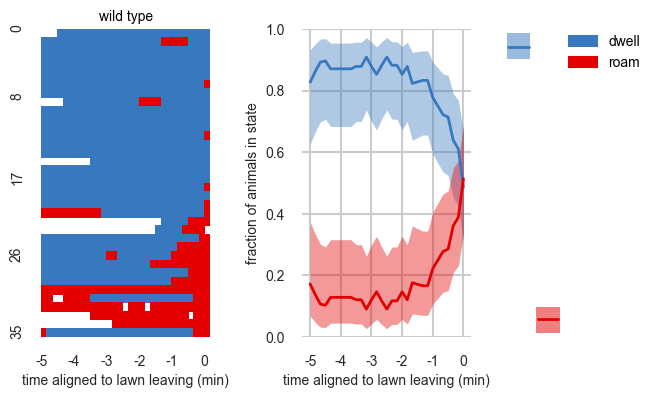

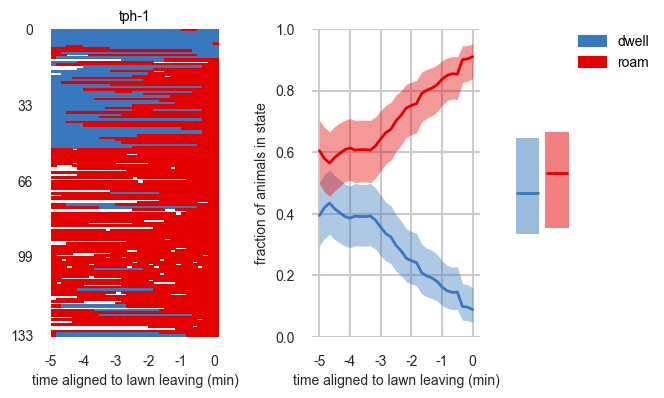

In [47]:
# ROAMING/DWELLING ALIGNED TO LAWN LEAVING
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
framesPerMin = 6

#align data to HPREV and LL
numMins = 5
binTimeBefore = (numMins*framesPerMin) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = 1#((numMins)*framesPerMin) # X minutes after
missingFracThresh = 0.9
Data = list(Data_subs.items())[0][1]
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],Data['bin_LawnExit_mostRecent']>0,binTimeBefore,binTimeAfter,dtype=float)
xticksToPlot = np.hstack((binTimeLine[0:-1:framesPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*framesPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / framesPerMin).astype(int)
timeLine2 = binTimeLine / framesPerMin
xticksToPlot2 = np.round(np.linspace(timeLine2[0], timeLine2[-1], len(xticksToPlot)))


Roam_LL_aligned = dict()
for d_key, d_val in Data_subs.items():
    binLawnExit = d_val['bin_LawnExit_mostRecent']
    if np.sum(np.sum(binLawnExit))<2:
        print("no LE: "+d_key)
        continue
        
    bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(d_val['bin_Midbody_fspeed'],~d_val['InLawnRunMask'],binLawnExit>0,binTimeBefore,binTimeAfter,dtype=float)
    
    f, ax = plt.subplots(1, 3, figsize=(7.5,4), gridspec_kw={'width_ratios': [2,2,0.7],'hspace':0,'wspace':0.7})
    ax, R_LL_dfToPlot = plotMLstates_Aligned_masked(
        ax,
        d_val['RD_states_Matrix_exog_Cent'],
        RD_hmm_Cent_exog,~d_val['InLawnRunMask'],
        binLawnExit,
        binTimeLine,
        binTimeBefore,
        binTimeAfter,
        framesPerMin,
        d_key,
        colors,
        numLastBins,
        False,
        figsize=(10,4))
    
    Roam_LL_aligned[d_key] = R_LL_dfToPlot
    
    ax[0].set_xlabel("time aligned to lawn leaving (min)")
#     ax[1].vlines(0, -200, 200, linestyle="--", color="black")
    ax[1].set_xlabel("time aligned to lawn leaving (min)")
#     ax[1].set_ylabel("fraction of animals roaming")
    ax[0].set_xticks(xticksToPlot + binTimeBefore)
    ax[0].set_xticklabels(xtickLabels,rotation=0)
    ax[1].set_xticks(xtickLabels)
    ax[1].set_xticklabels(xtickLabels)
#     ax[1].set_xlim(-numMins,numMins)
    ax[1].set_ylim(0,1)
#     ax[1].get_legend().remove()
    ax[1].set_frame_on(False)
    
    #get all R/D values so we can generate boxplots with confidence intervals
    RD_overall = d_val['RD_states_Matrix_exog_Cent']
    fracDwell_leavers = np.nanmean(~RD_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]],axis=1)
    fracRoam_leavers = np.nanmean(RD_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]],axis=1)
    fracDwellRoam = [fracDwell_leavers,fracRoam_leavers]
    fracDwellRoam_stacked = pd.DataFrame(data=stack_padding(fracDwellRoam).T,columns=['dwell','roam'])


    ###########
    #plot accompanying boxplots #change this to have the same look as the plots with SEM
    g = sns.boxplot(data=fracDwellRoam_stacked,
                showfliers=False,
                whis=0,
                palette = colors,
                saturation = 1,
                ax = ax[2])

    # DIY custom boxplot
    for i,box in enumerate(g.artists):
        box.set_edgecolor(mpl.colors.to_rgba(colors[i], 0))
        box.set_facecolor(mpl.colors.to_rgba(colors[i], 0.50))
        # iterate over whiskers and median lines
        for j in g.lines:
             j.set_color(mpl.colors.to_rgba(colors[i], 0))

    #make the medians pop
    m_width = 0.7
    medians = fracDwellRoam_stacked.melt().groupby("variable").median().reindex(['dwell','roam'])
    for i,xtick in enumerate(g.get_xticks()):
        g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= colors[i], linestyle='-', linewidth=2,zorder=3)

    ax[2].set_frame_on(False)
    ax[2].set_xticks([])
    ax[2].set_ylim(0,1)
    ax[2].set_yticks([]) 
    ##################
    
    #move axes around
    box = ax[2].get_position()
    ax[2].set_position([box.x0-0.08, box.y0, box.width, box.height])
    ax[2].set_frame_on(False)
    ax[2].set_xticks([])
    # create color map with colors and df.names
    cmap = dict(zip(fracDwellRoam_stacked.columns, colors))
    # create the rectangles for the legend
    patches = [Patch(color=v, label=k) for k, v in cmap.items()]
    # add the legend
    lgd = ax[2].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

    if saveFigures:
        outpath = os.path.join(subfolder,d_key+'_RoamingDwellingStatesAlignedToLeaving_'+str(numMins)+'minBefore'+'_'+datestring+'.png')
        plt.savefig(outpath,dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
    


In [48]:
#save raw data
dataToSave = []
for gen in genotypes:
    if gen in Roam_LL_aligned.keys():
        dataToSave.append(np.hstack((np.repeat(gen,Roam_LL_aligned[gen].shape[0]).reshape(-1,1), Roam_LL_aligned[gen])))
dataToSave = np.vstack(dataToSave)
data_aligned_df = pd.DataFrame(dataToSave).set_index(0)
data_aligned_df.to_csv(subfolder+"/"+"RoamDwell_LLaligned.csv")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tph-1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.473e-11 U_stat=5.900e+01
['wild type' 'tph-1'],[4.54236463e-18            nan]: ['****' 'nan']
Fraction of Time Roaming per animal that left
['wild type' 'tph-1'],2.4733227352149466e-11: ****


/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/numpy/lib/function_base.py:1423: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


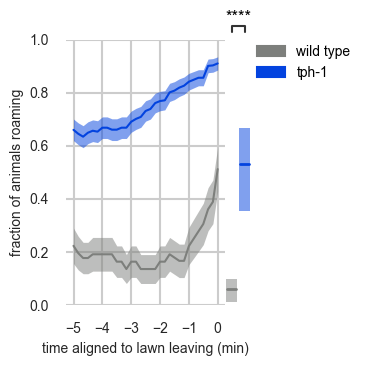

In [49]:
#ROAMING/DWELLING ALIGNED TO LAWN LEAVING - overlay the averages
#add the overall fraction of animals roaming for these leaving animals
from matplotlib.patches import Patch

numMins = 5
bin_RoamDwell_aligned, Mask_aligned, binTimeLine, binAlignIdx = \
alignSeveralDatas(Data_subs, genotypes, 'RD_states_Matrix_exog_Cent', 'InLawnRunMask_centroid', 'bin_LawnExit_mostRecent', binTimeBefore, binTimeAfter)

if len(genotypes)==2:
    fig, ax = plt.subplots(1, 2, figsize=aligned_overlay_figSize, sharey=False,gridspec_kw={'width_ratios': [3, 0.5],'hspace':0,'wspace':0})
else:
    fig, ax = plt.subplots(1, 2, figsize=(5,5), sharey=False,gridspec_kw={'width_ratios': [3, 1],'hspace':0,'wspace':0}) #good if the statannot goes too high


fracRoam_leavers = []
genList = []

i = 0
for d_key, d_val in Data_subs.items():
    data = bin_RoamDwell_aligned[d_key]
    if data.shape[0]<2:
        print("no LE: "+d_key)
        continue
        
    plotMeanSEMCurve(ax[0],data,missingFracThresh,gen,binTimeLine,framesPerMin,genotype_colors[i])
    
    #get all R/D values so we can generate boxplots with confidence intervals
    RD_overall = d_val['RD_states_Matrix_exog_Cent']
    to_append = np.nanmean(RD_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]],axis=1)
    fracRoam_leavers.append(to_append)
    genList.append(d_key)

    i = i+1

# ax[0].vlines(0, -200, 200, linestyle="--", color="black")
ax[0].set_ylim(0,1)
ax[0].set_xticks(xticksToPlot2)
# ax[0].set_xlim(-numMins,numMins)
ax[0].set_frame_on(False)
ax[0].set_ylabel("fraction of animals roaming")
ax[0].set_xlabel("time aligned to lawn leaving (min)")


#plot accompanying boxplots #change this to have the same look as the plots with SEM
fracRoam_leavers_stacked = pd.DataFrame(data=stack_padding(fracRoam_leavers).T,columns=genList)
g = sns.boxplot(data=fracRoam_leavers_stacked,
            showfliers=False,
            whis=0,
            palette = genotype_colors,
            saturation = 1,
            ax = ax[1])

# DIY custom boxplot
for i,box in enumerate(g.artists):
    box.set_edgecolor(mpl.colors.to_rgba(genotype_colors[i], 0))
    box.set_facecolor(mpl.colors.to_rgba(genotype_colors[i], 0.50))
    # iterate over whiskers and median lines
    for j in g.lines:
         j.set_color(mpl.colors.to_rgba(genotype_colors[i], 0))
            
#make the medians pop
m_width = 0.7
medians = fracRoam_leavers_stacked.melt().groupby("variable").median().reindex(genList)
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= genotype_colors[i], linestyle='-', linewidth=2,zorder=3)

ax[1].set_frame_on(False)
ax[1].set_xticks([])
ax[1].set_ylim(0,1)
ax[1].set_yticks([]) 


pairs = np.array(list(itertools.combinations(genList,2))) #use this instead in case one of the genotypes has no LE
annotator = Annotator(g, 
                      pairs, 
                      data=fracRoam_leavers_stacked)
annotator.configure(text_format='star', fontsize=12,loc='outside',test='Mann-Whitney', comparisons_correction="Bonferroni",verbose=2) 
_, fracRoam_leavers_statresults = annotator.apply_and_annotate()


# create color map with colors and df.names
cmap = dict(zip(fracRoam_leavers_stacked.columns, genotype_colors))
# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
# add the legend
ax[1].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

if saveFigures:
    outpath = os.path.join(subfolder,'RoamDwell_Cent_LawnExit_aligned'+str(numMins)+'minBefore'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)
    outpath = os.path.join(subfolder,'RoamDwell_Cent_LawnExit_aligned'+str(numMins)+'minBefore'+'_'+datestring+'.png')
    plt.savefig(outpath,dpi=300)

#calculate pvalues for given pairs, bonferroni corrected
timeIntervals = np.array(([-2,0],[1,3]))*6
pairs_out,p_vals, p_vals_starStrings = logit_ttest_CompareCurves_anytime(bin_RoamDwell_aligned,True,binAlignIdx,timeIntervals,pairs)

#print pairs and significance stars to a text file
with open(subfolder+'/FracStatesAligned_pVals.txt', 'w+') as f:
    f.write('Fraction of Animals Roaming: aligned to lawn exits')
    f.write('\n')
    f.write(str(timeIntervals))
    f.write('\n')
    for pair, p, p_Strs in zip(pairs_out,p_vals,p_vals_starStrings):
        p_Strs = str(p_Strs)
        print(str(pair)+','+str(p)+': '+p_Strs)
        f.write(str(pair)+','+str(p)+': '+p_Strs)
        f.write('\n')
    f.write('Fraction of Time Roaming per animal that left')
    print('Fraction of Time Roaming per animal that left')
    f.write('\n')
    for pair, p in zip(pairs_out,fracRoam_leavers_statresults):
        p_Strs = str(categorizePValue(p.data.pvalue))
        print(str(pair)+','+str(p.data.pvalue)+': '+p_Strs)
        f.write(str(pair)+','+str(p.data.pvalue)+': '+p_Strs)
        f.write('\n')
    f.close()



/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/numpy/ma/core.py:1184: RuntimeWarning: invalid value encountered in multiply
  masked_da = umath.multiply(m, da)
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
<ipython-input-50-3f3e040cc6d6>:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outpath,dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
<ipython-input-50-3f3e040cc6d6>:104: UserWarnin

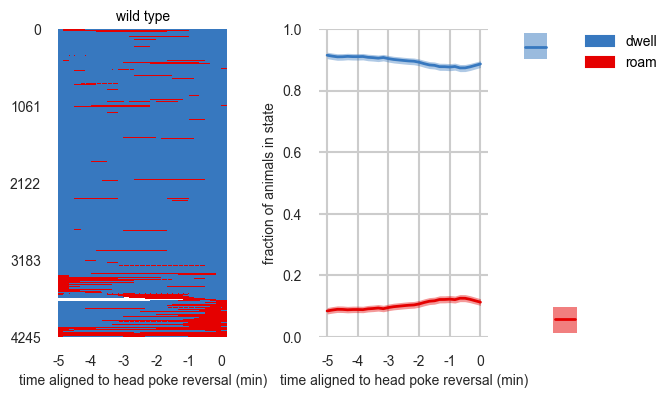

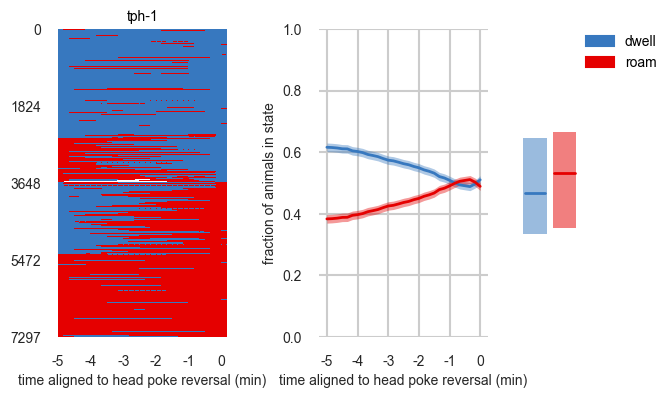

In [50]:
# ROAMING/DWELLING ALIGNED TO HEADPOKE REVERSAL
import matplotlib.pyplot as plt
framesPerMin = 6

#align data to HPREV and LL
numMins = 5
binTimeBefore = (numMins*framesPerMin) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = 1#((numMins)*framesPerMin) # X minutes after
missingFracThresh = 0.9
Data = list(Data_subs.items())[0][1]
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],Data['bin_LawnExit_mostRecent']>0,binTimeBefore,binTimeAfter,dtype=float)
xticksToPlot = np.hstack((binTimeLine[0:-1:framesPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*framesPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / framesPerMin).astype(int)
timeLine2 = binTimeLine / framesPerMin
xticksToPlot2 = np.round(np.linspace(timeLine2[0], timeLine2[-1], len(xticksToPlot)))

Roam_HPR_aligned = dict()
for d_key, d_val in Data_subs.items():
    binHeadpokeRev = d_val['bin_HeadPokeRev']
    bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(d_val['bin_Midbody_fspeed'],~d_val['InLawnRunMask'],binHeadpokeRev>0,binTimeBefore,binTimeAfter,dtype=float)
    f, ax = plt.subplots(1, 3, figsize=(7.5,4), gridspec_kw={'width_ratios': [2,2,0.7],'hspace':0,'wspace':0.7})
    ax, r_HPR_aligned = plotMLstates_Aligned_masked(ax,
                                     d_val['RD_states_Matrix_exog_Cent'],
                                     RD_hmm_Cent_exog,
                                     ~d_val['InLawnRunMask'],
                                     binHeadpokeRev,
                                     binTimeLine,
                                     binTimeBefore,
                                     binTimeAfter,
                                     framesPerMin,
                                     d_key,
                                     colors,
                                     numLastBins,
                                     False,
                                     figsize=(7.5,4))
    Roam_HPR_aligned[d_key] = r_HPR_aligned
    
    ax[0].set_xlabel("time aligned to head poke reversal (min)")
#     ax[1].vlines(0, -200, 200, linestyle="--", color="black")
    ax[1].set_xlabel("time aligned to head poke reversal (min)")
#     ax[1].set_ylabel("fraction of animals roaming")
    ax[0].set_xticks(xticksToPlot + binTimeBefore)
    ax[0].set_xticklabels(xtickLabels,rotation=0)
    ax[1].set_xticks(xtickLabels)
    ax[1].set_xticklabels(xtickLabels)
#     ax[1].set_xlim(-numMins,numMins)
    ax[1].set_ylim(0,1)
    ax[1].set_frame_on(False)
    
    #get all R/D values so we can generate boxplots with confidence intervals
    RD_overall = d_val['RD_states_Matrix_exog_Cent']
    fracDwell_leavers = np.nanmean(~RD_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]],axis=1)
    fracRoam_leavers = np.nanmean(RD_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]],axis=1)
    fracDwellRoam = [fracDwell_leavers,fracRoam_leavers]
    fracDwellRoam_stacked = pd.DataFrame(data=stack_padding(fracDwellRoam).T,columns=['dwell','roam'])

    ###########
    #plot accompanying boxplots #change this to have the same look as the plots with SEM
    g = sns.boxplot(data=fracDwellRoam_stacked,
                showfliers=False,
                whis=0,
                palette = colors,
                saturation = 1,
                ax = ax[2])

    # DIY custom boxplot
    for i,box in enumerate(g.artists):
        box.set_edgecolor(mpl.colors.to_rgba(colors[i], 0))
        box.set_facecolor(mpl.colors.to_rgba(colors[i], 0.50))
        # iterate over whiskers and median lines
        for j in g.lines:
             j.set_color(mpl.colors.to_rgba(colors[i], 0))

    #make the medians pop
    m_width = 0.7
    medians = fracDwellRoam_stacked.melt().groupby("variable").median().reindex(['dwell','roam'])
    for i,xtick in enumerate(g.get_xticks()):
        g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= colors[i], linestyle='-', linewidth=2,zorder=3)

    ax[2].set_frame_on(False)
    ax[2].set_xticks([])
    ax[2].set_ylim(0,1)
    ax[2].set_yticks([]) 
    ##################

    
    #move axes around
    box = ax[2].get_position()
    ax[2].set_position([box.x0-0.08, box.y0, box.width, box.height])
    ax[2].set_frame_on(False)
    ax[2].set_xticks([])
    # create color map with colors and df.names
    cmap = dict(zip(fracDwellRoam_stacked.columns, colors))
    # create the rectangles for the legend
    patches = [Patch(color=v, label=k) for k, v in cmap.items()]
    # add the legend
    lgd = ax[2].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

    
    if saveFigures:
        outpath = os.path.join(subfolder,d_key+'_RoamingDwellingStatesAlignedToHPREV_'+str(numMins)+'minBefore'+'_'+datestring+'.png')
        plt.savefig(outpath,dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')



In [51]:
#save raw data
dataToSave = []
for gen in genotypes:
    if gen in Roam_HPR_aligned.keys():
        dataToSave.append(np.hstack((np.repeat(gen,Roam_HPR_aligned[gen].shape[0]).reshape(-1,1), Roam_HPR_aligned[gen])))
dataToSave = np.vstack(dataToSave)
data_aligned_df = pd.DataFrame(dataToSave).set_index(0)
data_aligned_df.to_csv(subfolder+"/"+"RoamDwell_HPRaligned.csv")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tph-1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.362e-30 U_stat=1.554e+03
['wild type' 'tph-1'],[0. 0.]: ['****' '****']


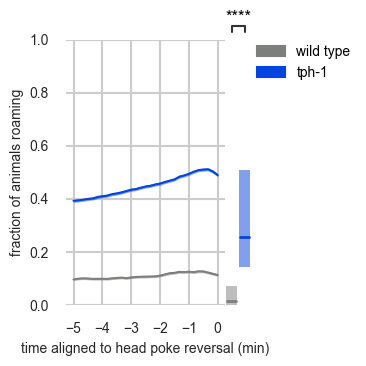

In [52]:
#ROAMING/DWELLING ALIGNED TO HEAD POKE REVERSAL - overlay the averages
#add the overall fraction of animals roaming for these leaving animals
from matplotlib.patches import Patch

numMins = 5
bin_RoamDwell_aligned, Mask_aligned, binTimeLine, binAlignIdx = \
alignSeveralDatas(Data_subs, genotypes, 'RD_states_Matrix_exog_Cent', 'InLawnRunMask_centroid', 'bin_HeadPokeRev', binTimeBefore, binTimeAfter)

if len(genotypes)==2:
    fig, ax = plt.subplots(1, 2, figsize=aligned_overlay_figSize, sharey=False,gridspec_kw={'width_ratios': [3, 0.5],'hspace':0,'wspace':0})
else:
    fig, ax = plt.subplots(1, 2, figsize=(5,5), sharey=False,gridspec_kw={'width_ratios': [3, 0.5],'hspace':0,'wspace':0}) #good if the statannot goes too high

fracRoam_pokers = []
i = 0
for d_key, d_val in Data_subs.items():
    data = bin_RoamDwell_aligned[d_key]
    if data.size==0:
        print("no LE: "+gen)
        continue
    plotMeanSEMCurve(ax[0],data,missingFracThresh,gen,binTimeLine,framesPerMin,genotype_colors[i])
    
    #get all R/D values so we can generate boxplots with confidence intervals
    RD_overall = d_val['RD_states_Matrix_exog_Cent']
    fracRoam_pokers.append(np.nanmean(RD_overall[np.where(np.sum(d_val['bin_HeadPokeRev'],axis=1)>0)[0]],axis=1))

    i = i+1

# ax[0].vlines(0, -200, 200, linestyle="--", color="black")
ax[0].set_ylim(0,1)
ax[0].set_xticks(xticksToPlot2)
# ax[0].set_xlim(-numMins,numMins)
ax[0].set_frame_on(False)
ax[0].set_ylabel("fraction of animals roaming")
ax[0].set_xlabel("time aligned to head poke reversal (min)")

# fracRoam_pokers_stacked = pd.DataFrame(data=stack_padding(fracRoam_pokers).T,columns=genotypes)
# #plot accompanying boxplots
# g = sns.boxplot(data=fracRoam_pokers_stacked,
#             showfliers=False,
#             whis=0,
#             palette = genotype_colors,
#             saturation = 1,
#             ax = ax[1])
# ax[1].set_frame_on(False)
# ax[1].set_xticks([])
# for patch in g.artists:
#     fc = patch.get_facecolor()
#     patch.set_facecolor(mpl.colors.to_rgba(fc, 0.75))
    
###############
#plot accompanying boxplots #change this to have the same look as the plots with SEM
fracRoam_pokers_stacked = pd.DataFrame(data=stack_padding(fracRoam_pokers).T,columns=genotypes)
g = sns.boxplot(data=fracRoam_pokers_stacked,
            showfliers=False,
            whis=0,
            palette = genotype_colors,
            saturation = 1,
            ax = ax[1])

# DIY custom boxplot
for i,box in enumerate(g.artists):
    box.set_edgecolor(mpl.colors.to_rgba(genotype_colors[i], 0))
    box.set_facecolor(mpl.colors.to_rgba(genotype_colors[i], 0.50))
    # iterate over whiskers and median lines
    for j in g.lines:
         j.set_color(mpl.colors.to_rgba(genotype_colors[i], 0))
            
#make the medians pop
m_width = 0.7
medians = fracRoam_pokers_stacked.melt().groupby("variable").median().reindex(genotypes)
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= genotype_colors[i], linestyle='-', linewidth=2,zorder=3)

ax[1].set_frame_on(False)
ax[1].set_xticks([])
ax[1].set_ylim(0,1)
ax[1].set_yticks([]) 
####################

annotator = Annotator(g, 
                      pairs, 
                      data=fracRoam_pokers_stacked)
# annotator.configure(text_format='star', fontsize=12,loc='inside',test='Mann-Whitney', comparisons_correction="Bonferroni",verbose=2) 
annotator.configure(text_format='star', fontsize=12,loc='outside',test='Mann-Whitney', comparisons_correction="Bonferroni",verbose=2) 
annotator.apply_test()
_ = annotator.annotate()



# create color map with colors and df.names
cmap = dict(zip(fracRoam_pokers_stacked.columns, genotype_colors))
# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
# add the legend
ax[1].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

if saveFigures:
    outpath = os.path.join(subfolder,'RoamDwell_Cent_HeadPokeRev_aligned'+str(numMins)+'minBefore'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)
    outpath = os.path.join(subfolder,'RoamDwell_Cent_HeadPokeRev_aligned'+str(numMins)+'minBefore'+'_'+datestring+'.png')
    plt.savefig(outpath,dpi=300)
    
#calculate pvalues for given pairs, bonferroni corrected
timeIntervals = np.array(([-2,0],[0,2]))*6
pairs_out,p_vals, p_vals_starStrings = logit_ttest_CompareCurves_anytime(bin_RoamDwell_aligned,True,binAlignIdx,timeIntervals,pairs)

#print pairs and significance stars to a text file
with open(subfolder+'/FracStatesAligned_pVals.txt', 'a+') as f:
    f.write('Fraction of Animals Roaming: aligned to head poke reversal')
    f.write('\n')
    f.write(str(timeIntervals))
    f.write('\n')
    for pair, p, p_Strs in zip(pairs_out,p_vals,p_vals_starStrings):
        p_Strs = str(p_Strs)
        print(str(pair)+','+str(p)+': '+p_Strs)
        f.write(str(pair)+','+str(p)+': '+p_Strs)
        f.write('\n')
    f.close()



/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
<ipython-input-56-66430dfe0745>:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outpath+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
<ipython-input-56-66430dfe0745>:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
<ipyth

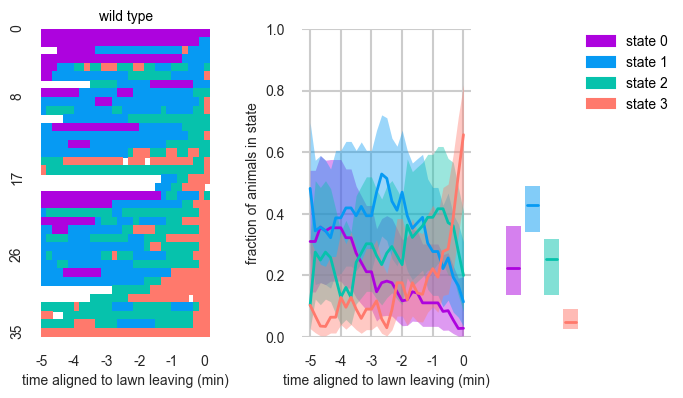

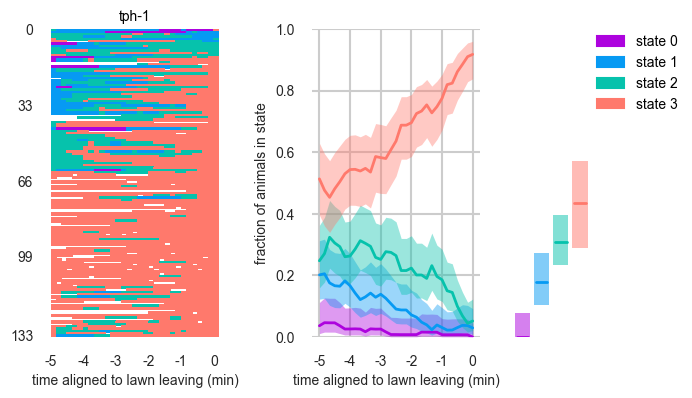

In [56]:
# AR-HMM STATES ALIGNED TO LAWN LEAVING
import matplotlib.pyplot as plt
framesPerMin = 6

#align data to HPREV and LL
numMins = 5
binTimeBefore = (numMins*framesPerMin) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = 1#((numMins)*framesPerMin) # X minutes after
missingFracThresh = 0.9
Data = list(Data_subs.items())[0][1]
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],Data['bin_LawnExit_mostRecent']>0,binTimeBefore,binTimeAfter,dtype=float)
xticksToPlot = np.hstack((binTimeLine[0:-1:framesPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*framesPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / framesPerMin).astype(int)
timeLine2 = binTimeLine / framesPerMin
xticksToPlot2 = np.round(np.linspace(timeLine2[0], timeLine2[-1], len(xticksToPlot)))

arHMMstates_LLaligned = dict()
for d_key, d_val in Data_subs.items():
    binLawnExit = d_val['bin_LawnExit_mostRecent']
    if np.sum(np.sum(binLawnExit))<2:
        print("no LE: "+d_key)
        continue
        
    bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(d_val['bin_Midbody_fspeed'],~d_val['InLawnRunMask'],binLawnExit>0,binTimeBefore,binTimeAfter,dtype=float)
    
    f, ax = plt.subplots(1, 3, figsize=(7.5,4), gridspec_kw={'width_ratios': [2,2,0.7],'hspace':0,'wspace':0.7})
    ax, a_LL_aligned = plotMLstates_Aligned_masked(
        ax,
        d_val['arHMM_MLstates'],
        arHMM_model,
        ~d_val['InLawnRunMask'],
        binLawnExit,
        binTimeLine,
        binTimeBefore,
        binTimeAfter,
        framesPerMin,
        d_key,
        arhmm_colors,
        numLastBins,
        False,
        figsize=(7.5,4))
    
    arHMMstates_LLaligned[d_key]= a_LL_aligned
    
    ax[0].set_xlabel("time aligned to lawn leaving (min)")
#     ax[1].vlines(0, -200, 200, linestyle="--", color="black")
    ax[1].set_xlabel("time aligned to lawn leaving (min)")
#     ax[1].set_ylabel("fraction of animals roaming")
    ax[0].set_xticks(xticksToPlot + binTimeBefore)
    ax[0].set_xticklabels(xtickLabels,rotation=0)
    ax[1].set_xticks(xtickLabels)
    ax[1].set_xticklabels(xtickLabels)
#     ax[1].set_xlim(-numMins,numMins)
    ax[1].set_ylim(0,1)
    ax[1].set_frame_on(False)
    
    #get all R/D values so we can generate barplots with confidence intervals
    MLstates_overall = d_val['arHMM_MLstates']
    fracstate0_leavers = np.nanmean(MLstates_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==0.0,axis=1)
    fracstate1_leavers = np.nanmean(MLstates_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==1.0,axis=1)
    fracstate2_leavers = np.nanmean(MLstates_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==2.0,axis=1)
    fracstate3_leavers = np.nanmean(MLstates_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==3.0,axis=1)

    fracARHMMstates = [fracstate0_leavers,fracstate1_leavers,fracstate2_leavers,fracstate3_leavers]
    fracARHMMstates_stacked = pd.DataFrame(data=stack_padding(fracARHMMstates).T,columns=['state 0','state 1','state 2','state 3'])
    
    ###########
    #plot accompanying boxplots #change this to have the same look as the plots with SEM
    g = sns.boxplot(data=fracARHMMstates_stacked,
                showfliers=False,
                whis=0,
                palette = arhmm_colors,
                saturation = 1,
                ax = ax[2])

    # DIY custom boxplot
    for i,box in enumerate(g.artists):
        box.set_edgecolor(mpl.colors.to_rgba(arhmm_colors[i], 0))
        box.set_facecolor(mpl.colors.to_rgba(arhmm_colors[i], 0.50))
        # iterate over whiskers and median lines
        for j in g.lines:
             j.set_color(mpl.colors.to_rgba(arhmm_colors[i], 0))

    #make the medians pop
    m_width = 0.6
    medians = fracARHMMstates_stacked.melt().groupby("variable").median().reindex(['state 0','state 1','state 2','state 3'])
    for i,xtick in enumerate(g.get_xticks()):
        g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= arhmm_colors[i], linestyle='-', linewidth=2,zorder=3)

    ax[2].set_frame_on(False)
    ax[2].set_xticks([])
    ax[2].set_ylim(0,1)
    ax[2].set_yticks([]) 
    ##################

    #move axes around
    box = ax[2].get_position()
    ax[2].set_position([box.x0-0.08, box.y0, box.width*1.3, box.height])
    ax[2].set_frame_on(False)
    ax[2].set_xticks([])
    # create color map with colors and df.names
    cmap = dict(zip(fracARHMMstates_stacked.columns, arhmm_colors))
    # create the rectangles for the legend
    patches = [Patch(color=v, label=k) for k, v in cmap.items()]
    # add the legend
    lgd = ax[2].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

    if saveFigures:
        outpath = os.path.join(subfolder,d_key+'arHMM_model'+'_kappa_'+str(arHMM_model.transitions.kappa)+'_numstates_'+str(arHMM_model.K)+'_StatesAlignedToLeaving_'+str(numMins)+'minBefore'+'_'+datestring)
        plt.savefig(outpath+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
        

In [57]:
#save raw data
dataToSave = []
for gen in genotypes:
    if gen in arHMMstates_LLaligned.keys():
        dataToSave.append(np.hstack((np.repeat(gen,arHMMstates_LLaligned[gen].shape[0]).reshape(-1,1), arHMMstates_LLaligned[gen])))
dataToSave = np.vstack(dataToSave)
data_aligned_df = pd.DataFrame(dataToSave).set_index(0)
data_aligned_df.to_csv(subfolder+"/"+"ARHMMstates_LLaligned.csv")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tph-1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:6.256e-11 U_stat=7.250e+01
['wild type' 'tph-1'],[2.93932468e-16            nan]: ['****' 'nan']


/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/numpy/lib/function_base.py:1423: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


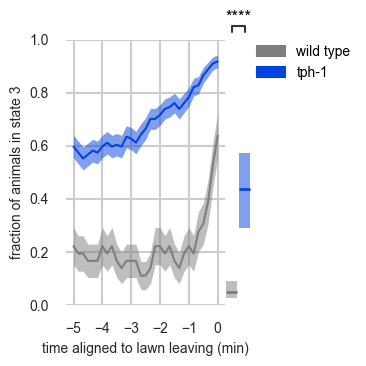

In [58]:
#AR-HMM State 3 ALIGNED TO LAWN LEAVING - overlay the averages
#add the overall fraction of animals in state 3 for these leaving animals
from matplotlib.patches import Patch

numMins = 5
bin_ARHMMstates_aligned, Mask_aligned, binTimeLine, binAlignIdx = \
alignSeveralDatas(Data_subs, genotypes, 'arHMM_MLstates', 'InLawnRunMask_centroid', 'bin_LawnExit_mostRecent', binTimeBefore, binTimeAfter)

if len(genotypes)==2:
    fig, ax = plt.subplots(1, 2, figsize=aligned_overlay_figSize, sharey=False,gridspec_kw={'width_ratios': [3, 0.5],'hspace':0,'wspace':0})
else:
    fig, ax = plt.subplots(1, 2, figsize=(5,4), sharey=False,gridspec_kw={'width_ratios': [3, 1],'hspace':0,'wspace':0.1}) #good if the statannot goes too high

fracstate3_leavers = []
genList = []

i = 0
for d_key, d_val in Data_subs.items():
#     print(d_key)
    data = bin_ARHMMstates_aligned[d_key]==3.0 #state 3
#     print(data.size)
    if data.shape[0]<2:
        print("no LE: "+d_key)
        i = i+1
        continue
        
    plotMeanSEMCurve(ax[0],data,missingFracThresh,gen,binTimeLine,framesPerMin,genotype_colors[i])
    
    #get all state 3 values so we can generate boxplots with confidence intervals
    state3_overall = d_val['arHMM_MLstates']==3.0
    fracstate3_leavers.append(np.nanmean(state3_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]],axis=1))
    genList.append(d_key)
    
    i = i+1

# ax[0].vlines(0, -200, 200, linestyle="--", color="black")
ax[0].set_ylim(0,1)
ax[0].set_xticks(xticksToPlot2)
# ax[0].set_xlim(-numMins,numMins)
ax[0].set_frame_on(False)
ax[0].set_ylabel("fraction of animals in state 3")
ax[0].set_xlabel("time aligned to lawn leaving (min)")

fracstate3_leavers_stacked = pd.DataFrame(data=stack_padding(fracstate3_leavers).T,columns=genList)
#plot accompanying boxplots #change this to have the same look as the plots with SEM
g = sns.boxplot(data=fracstate3_leavers_stacked,
            showfliers=False,
            whis=0,
            palette = genotype_colors,
            saturation = 1,
            ax = ax[1])

# DIY custom boxplot
for i,box in enumerate(g.artists):
    box.set_edgecolor(mpl.colors.to_rgba(genotype_colors[i], 0))
    box.set_facecolor(mpl.colors.to_rgba(genotype_colors[i], 0.50))
    # iterate over whiskers and median lines
    for j in g.lines:
         j.set_color(mpl.colors.to_rgba(genotype_colors[i], 0))
            
#make the medians pop
m_width = 0.7
medians = fracstate3_leavers_stacked.melt().groupby("variable").median().reindex(genotypes)
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= genotype_colors[i], linestyle='-', linewidth=2,zorder=3)

ax[1].set_frame_on(False)
ax[1].set_xticks([])
ax[1].set_ylim(0,1)
ax[1].set_yticks([]) 

pairs = np.array(list(itertools.combinations(genList,2))) #use this instead in case one of the genotypes has no LE
annotator = Annotator(g, 
                      pairs, 
                      data=fracstate3_leavers_stacked)
# annotator.configure(text_format='star', fontsize=12,loc='inside',test='Mann-Whitney', comparisons_correction="Bonferroni",verbose=2) 
annotator.configure(text_format='star', fontsize=12,loc='outside',test='Mann-Whitney', comparisons_correction="Bonferroni",verbose=2) 
annotator.apply_test()
_ = annotator.annotate()

# create color map with colors and df.names
cmap = dict(zip(fracstate3_leavers_stacked.columns, genotype_colors))
# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
# add the legend
lgd = ax[1].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

if saveFigures:
    outpath = os.path.join(subfolder,'ARHMM_State3_LawnExit_aligned'+str(numMins)+'minBefore'+'_'+datestring)
    plt.savefig(outpath+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')

    
#calculate pvalues for given pairs, bonferroni corrected
timeIntervals = np.array(([-2,0],[1,3]))*6
pairs_out,p_vals, p_vals_starStrings = logit_ttest_CompareCurves_anytime(bin_ARHMMstates_aligned,3.0,binAlignIdx,timeIntervals,pairs)

#print pairs and significance stars to a text file
with open(subfolder+'/FracStatesAligned_pVals.txt', 'a+') as f:
    f.write('Fraction of Animals State 3: aligned to lawn exits')
    f.write('\n')
    f.write(str(timeIntervals))
    f.write('\n')
    for pair, p, p_Strs in zip(pairs_out,p_vals,p_vals_starStrings):
        p_Strs = str(p_Strs)
        print(str(pair)+','+str(p)+': '+p_Strs)
        f.write(str(pair)+','+str(p)+': '+p_Strs)
        f.write('\n')
    f.close()


/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/numpy/ma/core.py:1184: RuntimeWarning: invalid value encountered in multiply
  masked_da = umath.multiply(m, da)
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
<ipython-input-59-3d0b3bb9e97f>:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outpath,dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
<ipython-input-59-3d0b3bb9e97f>:105: UserWarnin

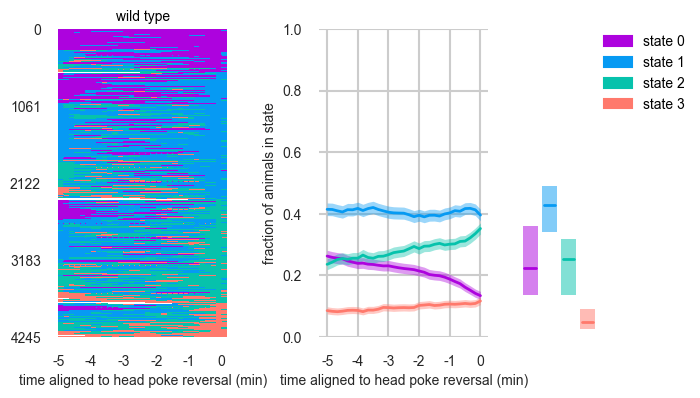

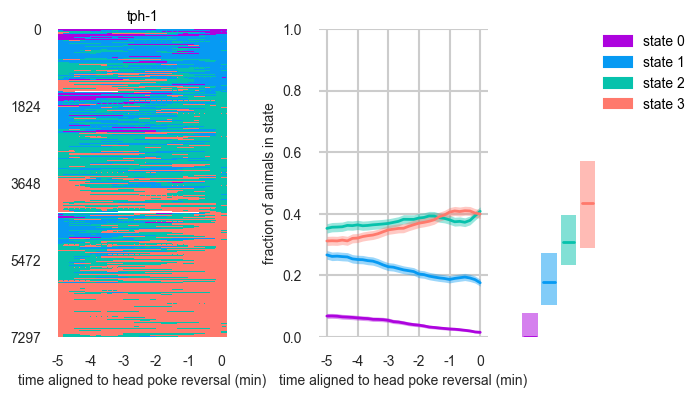

In [59]:
# AR-HMM STATES ALIGNED TO HEAD POKE REVERSAL
import matplotlib.pyplot as plt
framesPerMin = 6

#align data to HPREV and LL
numMins = 5
binTimeBefore = (numMins*framesPerMin) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = 1#((numMins)*framesPerMin) # X minutes after
missingFracThresh = 0.9
Data = list(Data_subs.items())[0][1]
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],Data['bin_LawnExit_mostRecent']>0,binTimeBefore,binTimeAfter,dtype=float)
xticksToPlot = np.hstack((binTimeLine[0:-1:framesPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*framesPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / framesPerMin).astype(int)
timeLine2 = binTimeLine / framesPerMin
xticksToPlot2 = np.round(np.linspace(timeLine2[0], timeLine2[-1], len(xticksToPlot)))

arHMMstates_HPRaligned = dict()
for d_key, d_val in Data_subs.items():
    binHeadpokeRev = d_val['bin_HeadPokeRev']
    bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(d_val['bin_Midbody_fspeed'],~d_val['InLawnRunMask'],binHeadpokeRev>0,binTimeBefore,binTimeAfter,dtype=float)
    
    f, ax = plt.subplots(1, 3, figsize=(7.5,4), gridspec_kw={'width_ratios': [2,2,0.7],'hspace':0,'wspace':0.7})
    ax, a_HPR_aligned = plotMLstates_Aligned_masked(ax,
                                     d_val['arHMM_MLstates'],
                                     arHMM_model,
                                     ~d_val['InLawnRunMask'],
                                     binHeadpokeRev,
                                     binTimeLine,
                                     binTimeBefore,
                                     binTimeAfter,
                                     framesPerMin,
                                     d_key,
                                     arhmm_colors,
                                     numLastBins,
                                     False,
                                     figsize=(7.5,4))
    arHMMstates_HPRaligned[d_key] = a_HPR_aligned
    
    ax[0].set_xlabel("time aligned to head poke reversal (min)")
#     ax[1].vlines(0, -200, 200, linestyle="--", color="black")
    ax[1].set_xlabel("time aligned to head poke reversal (min)")
#     ax[1].set_ylabel("fraction of animals roaming")
    ax[0].set_xticks(xticksToPlot + binTimeBefore)
    ax[0].set_xticklabels(xtickLabels,rotation=0)
    ax[1].set_xticks(xtickLabels)
    ax[1].set_xticklabels(xtickLabels)
#     ax[1].set_xlim(-numMins,numMins)
    ax[1].set_ylim(0,1)
    ax[1].set_frame_on(False)
    
    #get all R/D values so we can generate barplots with confidence intervals
    MLstates_overall = d_val['arHMM_MLstates']
    fracstate0_leavers = np.nanmean(MLstates_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==0.0,axis=1)
    fracstate1_leavers = np.nanmean(MLstates_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==1.0,axis=1)
    fracstate2_leavers = np.nanmean(MLstates_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==2.0,axis=1)
    fracstate3_leavers = np.nanmean(MLstates_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==3.0,axis=1)
    
    fracARHMMstates = [fracstate0_leavers,fracstate1_leavers,fracstate2_leavers,fracstate3_leavers]
    fracARHMMstates_stacked = pd.DataFrame(data=stack_padding(fracARHMMstates).T,columns=['state 0','state 1','state 2','state 3'])

    ###########
    #plot accompanying boxplots #change this to have the same look as the plots with SEM
    g = sns.boxplot(data=fracARHMMstates_stacked,
                showfliers=False,
                whis=0,
                palette = colors,
                saturation = 1,
                ax = ax[2])

    # DIY custom boxplot
    for i,box in enumerate(g.artists):
        box.set_edgecolor(mpl.colors.to_rgba(arhmm_colors[i], 0))
        box.set_facecolor(mpl.colors.to_rgba(arhmm_colors[i], 0.50))
        # iterate over whiskers and median lines
        for j in g.lines:
             j.set_color(mpl.colors.to_rgba(arhmm_colors[i], 0))

    #make the medians pop
    m_width = 0.6
    medians = fracARHMMstates_stacked.melt().groupby("variable").median().reindex(['state 0','state 1','state 2','state 3'])
    for i,xtick in enumerate(g.get_xticks()):
        g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= arhmm_colors[i], linestyle='-', linewidth=2,zorder=3)

    ax[2].set_frame_on(False)
    ax[2].set_xticks([])
    ax[2].set_ylim(0,1)
    ax[2].set_yticks([]) 
    ##################

    #move axes around
    box = ax[2].get_position()
    ax[2].set_position([box.x0-0.08, box.y0, box.width*1.3, box.height])
    ax[2].set_frame_on(False)
    ax[2].set_xticks([])
    # create color map with colors and df.names
    cmap = dict(zip(fracARHMMstates_stacked.columns, arhmm_colors))
    # create the rectangles for the legend
    patches = [Patch(color=v, label=k) for k, v in cmap.items()]
    # add the legend
    lgd = ax[2].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)
    if saveFigures:
        outpath = os.path.join(subfolder,d_key+'arHMM_model'+'_kappa_'+str(arHMM_model.transitions.kappa)+'_numstates_'+str(arHMM_model.K)+'_StatesAlignedToHPREV_'+str(numMins)+'minBefore'+'_'+datestring+'.png')
        plt.savefig(outpath,dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
        

In [60]:
#save raw data
dataToSave = []
for gen in genotypes:
    if gen in arHMMstates_HPRaligned.keys():
        dataToSave.append(np.hstack((np.repeat(gen,arHMMstates_HPRaligned[gen].shape[0]).reshape(-1,1), arHMMstates_HPRaligned[gen])))
dataToSave = np.vstack(dataToSave)
data_aligned_df = pd.DataFrame(dataToSave).set_index(0)
data_aligned_df.to_csv(subfolder+"/"+"ARHMMstates_HPRaligned.csv")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tph-1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.654e-26 U_stat=2.057e+03
['wild type' 'tph-1'],[0.00000000e+000 8.15701089e-236]: ['****' '****']


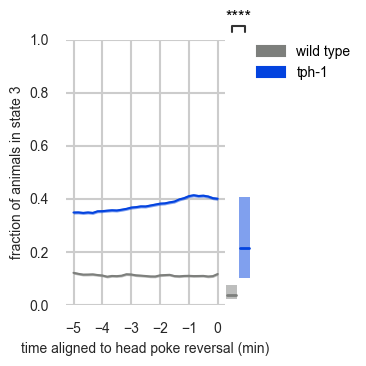

In [61]:
#AR-HMM State 3 ALIGNED TO Head Poke Reversal - overlay the averages
#add the overall fraction of animals in state 3 for these leaving animals
from matplotlib.patches import Patch

numMins = 5
bin_ARHMMstates_aligned, Mask_aligned, binTimeLine, binAlignIdx = \
alignSeveralDatas(Data_subs, genotypes, 'arHMM_MLstates', 'InLawnRunMask_centroid', 'bin_HeadPokeRev', binTimeBefore, binTimeAfter)

if len(genotypes)==2:
    fig, ax = plt.subplots(1, 2, figsize=aligned_overlay_figSize, sharey=False,gridspec_kw={'width_ratios': [3, 0.5],'hspace':0,'wspace':0})
else:
    fig, ax = plt.subplots(1, 2, figsize=(5,4), sharey=False,gridspec_kw={'width_ratios': [3, 1],'hspace':0,'wspace':0.1}) #good if the statannot goes too high

fracstate3_pokers = []
i = 0
for d_key, d_val in Data_subs.items():
    data = bin_ARHMMstates_aligned[d_key]==3.0 #state 3
    if data.size==0:
        print("no LE: "+gen)
        continue
    plotMeanSEMCurve(ax[0],data,missingFracThresh,gen,binTimeLine,framesPerMin,genotype_colors[i])
    
    #get all state 3 values so we can generate boxplots with confidence intervals
    state3_overall = d_val['arHMM_MLstates']==3.0
    fracstate3_pokers.append(np.nanmean(state3_overall[np.where(np.sum(d_val['bin_HeadPokeRev'],axis=1)>0)[0]],axis=1))

    i = i+1

# ax[0].vlines(0, -200, 200, linestyle="--", color="black")
ax[0].set_ylim(0,1)
ax[0].set_xticks(xticksToPlot2)
# ax[0].set_xlim(-numMins,numMins)
ax[0].set_frame_on(False)
ax[0].set_ylabel("fraction of animals in state 3")
ax[0].set_xlabel("time aligned to head poke reversal (min)")

fracstate3_pokers_stacked = pd.DataFrame(data=stack_padding(fracstate3_pokers).T,columns=genotypes)
#plot accompanying boxplots #change this to have the same look as the plots with SEM
g = sns.boxplot(data=fracstate3_pokers_stacked,
            showfliers=False,
            whis=0,
            palette = genotype_colors,
            saturation = 1,
            ax = ax[1])

# DIY custom boxplot
for i,box in enumerate(g.artists):
    box.set_edgecolor(mpl.colors.to_rgba(genotype_colors[i], 0))
    box.set_facecolor(mpl.colors.to_rgba(genotype_colors[i], 0.50))
    # iterate over whiskers and median lines
    for j in g.lines:
         j.set_color(mpl.colors.to_rgba(genotype_colors[i], 0))
            
#make the medians pop
m_width = 0.7
medians = fracstate3_pokers_stacked.melt().groupby("variable").median().reindex(genotypes)
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= genotype_colors[i], linestyle='-', linewidth=2,zorder=3)

ax[1].set_frame_on(False)
ax[1].set_xticks([])
ax[1].set_ylim(0,1)
ax[1].set_yticks([]) 

annotator = Annotator(g, 
                      pairs, 
                      data=fracstate3_pokers_stacked)
# annotator.configure(text_format='star', fontsize=12,loc='inside',test='Mann-Whitney', comparisons_correction="Bonferroni",verbose=2) 
annotator.configure(text_format='star', fontsize=12,loc='outside',test='Mann-Whitney', comparisons_correction="Bonferroni",verbose=2) 
annotator.apply_test()
_ = annotator.annotate()

# create color map with colors and df.names
cmap = dict(zip(fracstate3_pokers_stacked.columns, genotype_colors))
# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
# add the legend
lgd = ax[1].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

if saveFigures:
    outpath = os.path.join(subfolder,'ARHMM_State3_HeadPokeRev_aligned'+str(numMins)+'minBeforeAndAfter'+'_'+datestring+'.pdf')
    plt.savefig(outpath+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')

#calculate pvalues for given pairs, bonferroni corrected
timeIntervals = np.array(([-2,0],[0,2]))*6
pairs_out,p_vals, p_vals_starStrings = logit_ttest_CompareCurves_anytime(bin_ARHMMstates_aligned,3.0,binAlignIdx,timeIntervals,pairs)

#print pairs and significance stars to a text file
with open(subfolder+'/FracStatesAligned_pVals.txt', 'a+') as f:
    f.write('Fraction of Animals State 3: aligned to head poke reversals')
    f.write('\n')
    f.write(str(timeIntervals))
    f.write('\n')
    for pair, p, p_Strs in zip(pairs_out,p_vals,p_vals_starStrings):
        p_Strs = str(p_Strs)
        print(str(pair)+','+str(p)+': '+p_Strs)
        f.write(str(pair)+','+str(p)+': '+p_Strs)
        f.write('\n')
    f.close()


wild type 12
tph-1 113
downsample!
['wild type' 'tph-1'],[0.00480125]: ['**']


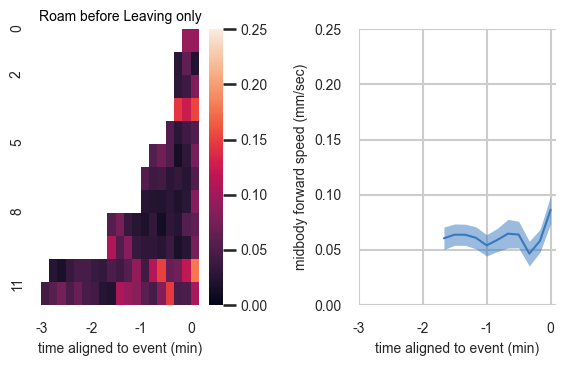

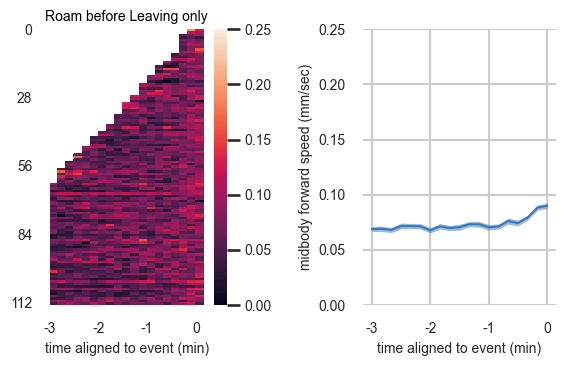

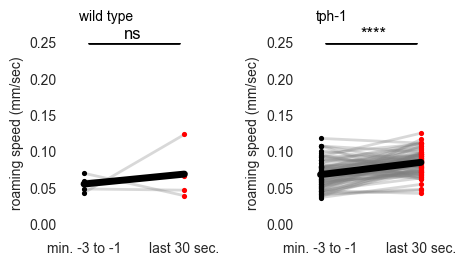

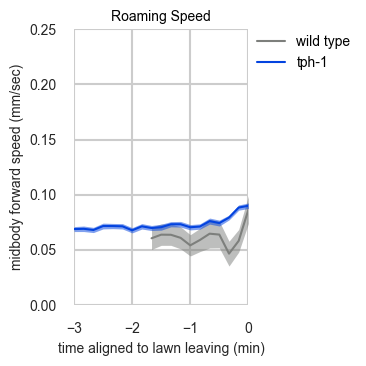

In [62]:
#Plot roaming speed aligned to lawn leaving
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
binsPerMin = 6

#align data to HPREV and LL
numMins = 3
binTimeBefore = (numMins*framesPerMin) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = 1#((numMins)*framesPerMin) # X minutes after
missingFracThresh = 0.7
Data = list(Data_subs.items())[0][1]
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],Data['bin_LawnExit_mostRecent']>0,binTimeBefore,binTimeAfter,dtype=float)
xticksToPlot = np.hstack((binTimeLine[0:-1:framesPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*framesPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / framesPerMin).astype(int)
timeLine2 = binTimeLine / framesPerMin
xticksToPlot2 = np.round(np.linspace(timeLine2[0], timeLine2[-1], len(xticksToPlot)))

ymin = 0
# ymax = 0.18
ymax = 0.25 #inedible food

fig_overlay, ax_overlay = plt.subplots(1, 1, figsize=aligned_overlay_figSize)
#paired plots
f_paired,axs_paired = plt.subplots(1,len(genotypes),figsize=(2.5*len(genotypes),3)) #for 2, use 2.5x
if len(genotypes)==1: #just in case there's only one genotype
    axs_paired = [axs_paired]

delta_RoamingSpeed = []
RoamingSpeed_LLaligned = dict()
pairedPlots_pvals_dict = dict()
i=0
for d_key, d_val in Data_subs.items():
    _, MLstatesRuns = getStateRunsBeforeEvent(d_val['RD_states_Matrix_exog_Cent'],True,d_val['bin_LawnExit_mostRecent'])
    binLawnExit_roam = np.logical_and(d_val['bin_LawnExit_mostRecent'],d_val['RD_states_Matrix_exog_Cent']) #subselect lawn exits that derive from roaming states
    LastRoam_inLawn = np.logical_and(~MLstatesRuns.mask,d_val['InLawnRunMask']) #True and True, invert it for the mask

    if np.sum(np.sum(binLawnExit_roam))<2:
        print("no LE: "+d_key)
        continue
        
    LL_aligned, mask_aligned, binTimeLine, binAlignIdx = \
    alignData_masked_lastRunOnly(d_val['bin_Midbody_fspeed'], ~LastRoam_inLawn, binLawnExit_roam, binTimeBefore, binTimeAfter, dtype=float)
    
    last30seconds = np.nanmean(LL_aligned[:,-3:],axis=1).reshape(-1,1)
    prev2minutes = np.nanmean(LL_aligned[:,:12],axis=1).reshape(-1,1)
    goodIdx = np.where(np.logical_and(~np.isnan(last30seconds),~np.isnan(prev2minutes)))[0]
    last30seconds = last30seconds[goodIdx]
    prev2minutes = prev2minutes[goodIdx]
    speedDiff = last30seconds-prev2minutes
    delta_RoamingSpeed.append(speedDiff.ravel())
    
    stat,pval = wilcoxon(prev2minutes,last30seconds)
    pairedPlots_pvals_dict[d_key] = pval
    axs_paired[i].set_frame_on(False)
    
    downsample = False
    print(d_key+' '+str(LL_aligned.shape[0]))
    #downsample paired plots to 100 datapoints if more than that
    if LL_aligned.shape[0]>100:
        print('downsample!')
        randIdx = np.random.choice(LL_aligned.shape[0], 100, replace=False)
        LL_aligned_toPlot = LL_aligned[randIdx,:]
        last30seconds_toPlot = np.nanmean(LL_aligned_toPlot[:,-3:],axis=1).reshape(-1,1)
        prev2minutes_toPlot = np.nanmean(LL_aligned_toPlot[:,:12],axis=1).reshape(-1,1)
        goodIdx_toPlot = np.where(np.logical_and(~np.isnan(last30seconds_toPlot),~np.isnan(prev2minutes_toPlot)))[0]
        last30seconds_toPlot = last30seconds_toPlot[goodIdx_toPlot]
        prev2minutes_toPlot = prev2minutes_toPlot[goodIdx_toPlot]
        downsample = True

    if not downsample:
        g = pairedScatterPlot(axs_paired[i],prev2minutes,last30seconds,'black','gray','red',0.3)
    else:
        g = pairedScatterPlot(axs_paired[i],prev2minutes_toPlot,last30seconds_toPlot,'black','gray','red',0.3)
        
    g.set_xticks([1,2])
    g.set_xticklabels(['min. -3 to -1','last 30 sec.'])
    g.set_xlabel('')
    g.set_ylabel('roaming speed (mm/sec)')
    g.set_xlim(0.9,2.1)
    g.set_ylim(0,ymax)
    g.text(1.4, ymax+0.005, categorizePValue(pval),fontsize=12)
    x1, y1 = [1.05, 1.95], [ymax,ymax]
    g.plot(x1, y1,linewidth=2,color='black')
    g.text(0.95, ymax+0.03,d_key,fontsize=10) #plot title

    fig,axs = plt.subplots(1,2,figsize=(6,4))
    axs = plotAligned_masked(axs, LL_aligned, binTimeLine, binTimeBefore,ymin, ymax, binsPerMin, 'midbody forward speed (mm/sec)', 'Roam before Leaving only', colors, "length",
                                False, binAlignIdx, binTimeBefore,True,missingFracThresh)
    
    RoamingSpeed_LLaligned[d_key] = LL_aligned

    axs[1].set_frame_on(False)
    axs[1].set_ylim([ymin, ymax])
  
    if saveFigures:
        outpath = os.path.join(subfolder,d_key+'_RoamingSpeedAlignedToLeaving_'+str(numMins)+'minBefore'+'_'+datestring)
        plt.savefig(outpath+'.pdf',bbox_extra_artists=(), bbox_inches='tight')
        plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(), bbox_inches='tight')
        
    
    plotMeanSEMCurve(ax_overlay,LL_aligned,missingFracThresh,d_key,binTimeLine,binsPerMin,genotype_colors[i])
    i+=1

# save the paired plots
plt.figure(f_paired.number)
if saveFigures:
    outpath = os.path.join(subfolder,'RoamingSpeed_pairedPlots'+'_'+datestring)
    plt.savefig(outpath+'.png',dpi=300)#,bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(outpath+'.pdf')#,bbox_extra_artists=(lgd,), bbox_inches='tight')
    
#save pvalues
pval_df = pd.DataFrame.from_dict(pairedPlots_pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pval_df["p value"]])
pval_df.to_csv(subfolder+"/"+"RoamingSpeed_prev2min_last30sec"+"_WilcoxonSignedRank"+"_pvalues.csv")

# plot overlayed roaming speed
plt.figure(fig_overlay.number)
ax_overlay.set_frame_on(False)
ax_overlay.set_ylim(ymin,ymax)
ax_overlay.set_xticks(xticksToPlot2)
ax_overlay.set_xlim(-numMins,0)
ax_overlay.set_title('Roaming Speed')
ax_overlay.set_ylabel("midbody forward speed (mm/sec)")
ax_overlay.set_xlabel("time aligned to lawn leaving (min)")
lgd = ax_overlay.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

if saveFigures:
    outpath = os.path.join(subfolder,'RoamingSpeed_AlignedtoLeaving_5minBefore'+'_'+datestring)
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(outpath+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
   
#calculate pvalues for given pairs, bonferroni corrected
timeIntervals = np.array([[-3,0]]) #last 30 seconds
p_vals, p_vals_starStrings = mwuCompareCurves_other_anytime(RoamingSpeed_LLaligned,binAlignIdx,timeIntervals,pairs)


#print pairs and significance stars to a text file
with open(subfolder+'/FracStatesAligned_pVals.txt', 'a+') as f:
    f.write('Roaming speed: aligned to lawn leaving')
    f.write('\n')
    f.write(str(timeIntervals))
    f.write('\n')
    for pair, p, p_Strs in zip(pairs,p_vals,p_vals_starStrings):
        p_Strs = str(p_Strs)
        print(str(pair)+','+str(p)+': '+p_Strs)
        f.write(str(pair)+','+str(p)+': '+p_Strs)
        f.write('\n')
    f.close()



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tph-1: Custom statistical test, P_val:3.933e-01


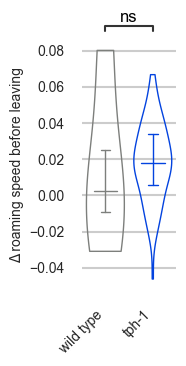

In [63]:
#plot and save delta roaming speed comparisons
import scikit_posthocs as sp

delta_RoamingSpeed_df = pd.DataFrame(data=stack_padding(delta_RoamingSpeed).T,columns=genotypes)
delta_RoamingSpeed_stacked = delta_RoamingSpeed_df.melt(var_name='groups', value_name='values')

pvalsToShowInOrder = []   
if len(genotypes)==2: 
    #define samples
    group1 = delta_RoamingSpeed_stacked[delta_RoamingSpeed_stacked['groups']==genotypes[0]].dropna()
    group2 = delta_RoamingSpeed_stacked[delta_RoamingSpeed_stacked['groups']==genotypes[1]].dropna()
    #perform independent two sample Mann-Whitney test
    _, pval_adj = mannwhitneyu(group1['values'], group2['values'])
    pvalsToShowInOrder = [pval_adj]
elif len(genotypes)>2:
    pval_adj = pval_adj = sp.posthoc_dunn(delta_RoamingSpeed_stacked,val_col='values', group_col='groups', p_adjust = 'bonferroni')
    pvalsToShowInOrder = []
    for p in pairs:
        pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])
else:
    raise Exception("you need at least two genotypes to compare.")

    
if len(genotypes)==2:
    f,ax = plt.subplots(1,1,figsize=(2.2,4))
else:
    f,ax = plt.subplots(1,1,figsize=(0.6*len(genotypes),7))
# f,ax = plt.subplots(1,1,figsize=(1,3))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

g = customViolinBoxPlot(delta_RoamingSpeed_df, genotype_colors, ax)
g.set_xticklabels(labels=genotypes,rotation=45,ha='right')
g.set_ylabel(u'Δ roaming speed before leaving')

pairs = np.array(list(itertools.combinations(genotypes,2))) #use this instead in case one of the genotypes has no LE
if pairs.size>0:
    g.set_xlabel('')
    annotator = Annotator(g, 
                          pairs, 
                          data=delta_RoamingSpeed_stacked,
                            x='groups',
                          y='values')
    annotator.configure(text_format='star', loc='outside', fontsize=12)
    annotator.set_pvalues(pvalsToShowInOrder)
    _ = annotator.annotate()

if saveFigures:
    outpath = os.path.join(subfolder,'RoamingSpeed_prev2min_last30sec_Diff'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)
    
#save pvalues
pvals_dict = dict()
for i,p in enumerate(pairs):
    pvals_dict[p[0]+', '+p[1]] = pvalsToShowInOrder[i]
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pvalsToShowInOrder])
if len(genotypes)==2:
    pval_df.to_csv(subfolder+"/"+"Delta_RoamingSpeed"+"_MannWhitneyU"+"_pvalues.csv")
elif len(genotypes)>2:
    pval_df.to_csv(subfolder+"/"+"Delta_RoamingSpeed"+"_postHocDunn"+"_pvalues.csv")
else:
    raise Exception("you need at least two genotypes to compare.")


In [64]:
#save data
dataToSave = []
for gen in genotypes:
    if gen in RoamingSpeed_LLaligned.keys():
        dataToSave.append(np.hstack((np.repeat(gen,RoamingSpeed_LLaligned[gen].shape[0]).reshape(-1,1), RoamingSpeed_LLaligned[gen].filled(np.nan))))
dataToSave = np.vstack(dataToSave)
data_aligned_df = pd.DataFrame(dataToSave).set_index(0)
data_aligned_df.to_csv(subfolder+"/"+"RoamingSpeed_LLaligned.csv")


['wild type' 'tph-1'],[0.00037947]: ['***']


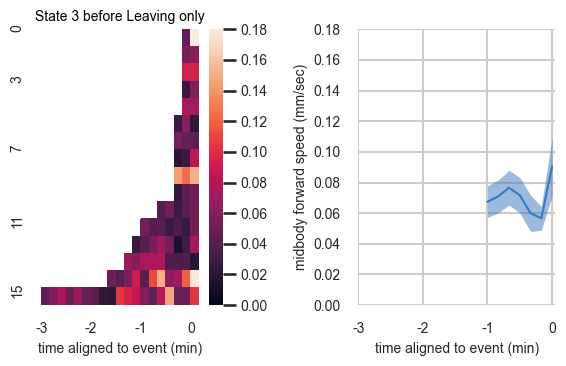

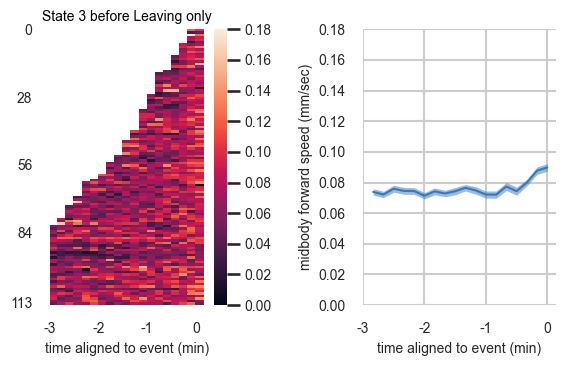

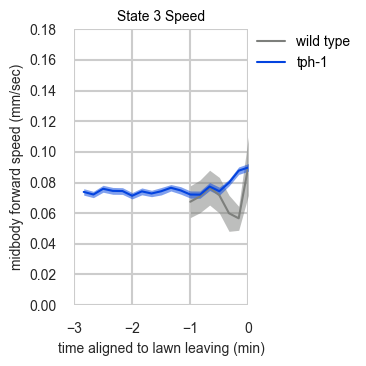

In [65]:
#Plot state 3 speed aligned to lawn leaving
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
binsPerMin = 6

#align data to HPREV and LL
numMins = 3
binTimeBefore = (numMins*framesPerMin) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = 1#((numMins)*framesPerMin) # X minutes after
missingFracThresh = 0.7
Data = list(Data_subs.items())[0][1]
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],Data['bin_LawnExit_mostRecent']>0,binTimeBefore,binTimeAfter,dtype=float)
xticksToPlot = np.hstack((binTimeLine[0:-1:framesPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*framesPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / framesPerMin).astype(int)
timeLine2 = binTimeLine / framesPerMin
xticksToPlot2 = np.round(np.linspace(timeLine2[0], timeLine2[-1], len(xticksToPlot)))

ymin = 0
ymax = 0.18

fig_overlay, ax_overlay = plt.subplots(1, 1, figsize=aligned_overlay_figSize)

State3Speed_LLaligned = dict()
i=0
for d_key, d_val in Data_subs.items():
    _, MLstatesRuns = getStateRunsBeforeEvent(d_val['arHMM_MLstates'],3.0,d_val['bin_LawnExit_mostRecent'])
    binLawnExit_state3 = np.logical_and(d_val['bin_LawnExit_mostRecent'],d_val['arHMM_MLstates']==3.0) #subselect lawn exits that derive from roaming states
    LastState3_inLawn = np.logical_and(~MLstatesRuns.mask,d_val['InLawnRunMask']) #True and True, invert it for the mask

    if np.sum(np.sum(binLawnExit_state3))<2:
        print("no LE: "+d_key)
        continue
        
    LL_aligned, mask_aligned, binTimeLine, binAlignIdx = \
    alignData_masked_lastRunOnly(d_val['bin_Midbody_fspeed'], ~LastState3_inLawn, binLawnExit_state3, binTimeBefore, binTimeAfter, dtype=float)

    fig,axs = plt.subplots(1,2,figsize=(6,4))
    axs = plotAligned_masked(axs, LL_aligned, binTimeLine, binTimeBefore,ymin, ymax, binsPerMin, 'midbody forward speed (mm/sec)', 'State 3 before Leaving only', colors, "length",
                                False, binAlignIdx, binTimeBefore,True,missingFracThresh)
    
    State3Speed_LLaligned[d_key] = LL_aligned

    axs[1].set_frame_on(False)
    axs[1].set_ylim([ymin, ymax])
  
    if saveFigures:
        outpath = os.path.join(subfolder,d_key+'_State3SpeedAlignedToLeaving_'+str(numMins)+'minBefore'+'_'+datestring)
        plt.savefig(outpath+'.pdf',bbox_extra_artists=(), bbox_inches='tight')
        plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(), bbox_inches='tight')
        
    
    plotMeanSEMCurve(ax_overlay,LL_aligned,missingFracThresh,d_key,binTimeLine,binsPerMin,genotype_colors[i])
    i+=1

plt.figure(fig_overlay.number)
ax_overlay.set_frame_on(False)
ax_overlay.set_ylim(ymin,ymax)
ax_overlay.set_xticks(xticksToPlot2)
ax_overlay.set_xlim(-numMins,0)
ax_overlay.set_title('State 3 Speed')
ax_overlay.set_ylabel("midbody forward speed (mm/sec)")
ax_overlay.set_xlabel("time aligned to lawn leaving (min)")
lgd = ax_overlay.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)
if saveFigures:
    outpath = os.path.join(subfolder,'State3Speed_AlignedtoLeaving_5minBefore'+'_'+datestring)
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(outpath+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

#calculate pvalues for given pairs, bonferroni corrected
timeIntervals = np.array([[-3,0]])
p_vals, p_vals_starStrings = mwuCompareCurves_other_anytime(State3Speed_LLaligned,binAlignIdx,timeIntervals,pairs)

#print pairs and significance stars to a text file
with open(subfolder+'/FracStatesAligned_pVals.txt', 'a+') as f:
    f.write('State 3 speed: aligned to lawn leaving')
    f.write('\n')
    f.write(str(timeIntervals))
    f.write('\n')
    for pair, p, p_Strs in zip(pairs,p_vals,p_vals_starStrings):
        p_Strs = str(p_Strs)
        print(str(pair)+','+str(p)+': '+p_Strs)
        f.write(str(pair)+','+str(p)+': '+p_Strs)
        f.write('\n')
    f.close()


In [66]:
#save data
dataToSave = []
for gen in genotypes:
    if gen in State3Speed_LLaligned.keys():
        dataToSave.append(np.hstack((np.repeat(gen,State3Speed_LLaligned[gen].shape[0]).reshape(-1,1), State3Speed_LLaligned[gen])))
dataToSave = np.vstack(dataToSave)
data_aligned_df = pd.DataFrame(dataToSave).set_index(0)
data_aligned_df.to_csv(subfolder+"/"+"State3Speed_LLaligned.csv")


### Comparisons of state durations, and probabilities of lawn exiting given states

Overall: ['wild type' 'tph-1'],3.346852037575772e-13,****


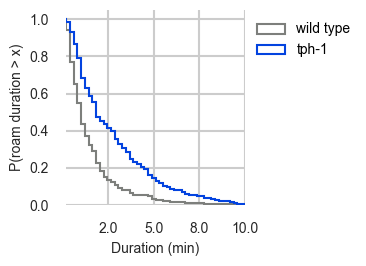

In [67]:
#Compare Roaming durations overall and before Leaving
from scipy.stats import ks_2samp
fig,axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(4,3))

durBins = np.linspace(0,10*6,50)
ticklabels=np.round((10/60*np.linspace(0,durBins[-1],5))).astype(str)

i = 0
roamDur_across_genotypes = dict()
roamDur_beforeLeaving_across_genotypes = dict()
for d_key, d_val in Data_subs.items():
    infDurations_RD_ALL = computeStateDurations(d_val['RD_states_Matrix_exog_Cent'].astype(int).filled(25))
    roamDur_across_genotypes[d_key] = infDurations_RD_ALL[1]
    axs.hist(infDurations_RD_ALL[1],bins=durBins,color=genotype_colors[i],density=True,alpha=1,histtype='step',cumulative=-1,lw=1.5,label=d_key)
    
    i = i+1
    
plt.box(False)
axs.set_xticks(ticks=np.linspace(0,durBins[-1],5))
axs.set_xticklabels(ticklabels)
axs.set_xlim([durBins[1],durBins[-1]])
# axs.set_yscale("log", basey=10)
axs.set_xlabel('Duration (min)')
axs.set_ylabel('P(roam duration > x)')
axs.legend(bbox_to_anchor=(1, 1),loc="upper left",frameon=False)
if saveFigures:
    outpath = os.path.join(subfolder,'Roam_Durations_overall'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

#Perform a Kolmogorov-Smirnov 2sample test across all genotype pairs, and then Bonferroni correct it
pvalsToShowInOrder = []
for i, p in enumerate(pairs):
    _,pval = ks_2samp(roamDur_across_genotypes[p[0]], roamDur_across_genotypes[p[1]], alternative='two-sided')
    pvalsToShowInOrder.append(pval)
#     print(p,pval)
pvalsToShowInOrder = np.array(pvalsToShowInOrder)*len(pairs) #Bonferroni correct


#print pairs and significance stars to a text file
with open(subfolder+'/RoamDuration_pVals.txt', 'a') as f:
    f.write('Roam Duration:')
    f.write('\n')
    for pair, p in zip(pairs,pvalsToShowInOrder):
        print('Overall: '+str(pair)+','+str(p)+','+str(categorizePValue(p)))
        f.write(str(pair)+','+str(p)+','+str(categorizePValue(p)))
        f.write('\n')
    f.write('Roam Duration Overall vs. before Leaving:')
    f.write('\n')
    f.close()
    


before Leaving: ['wild type' 'tph-1'],3.324297579039214e-05,****


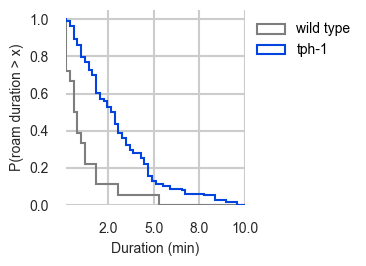

In [68]:
#Compare Roaming durations before Leaving
from scipy.stats import ks_2samp
fig,axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(4,3))

durBins = np.linspace(0,10*6,50)
ticklabels=np.round((10/60*np.linspace(0,durBins[-1],5))).astype(str)

i = 0
roamDur_across_genotypes = dict()
roamDur_beforeLeaving_across_genotypes = dict()
for d_key, d_val in Data_subs.items():    
    roamDurbL = computeStateDurationsBeforeEvent(d_val['RD_states_Matrix_exog_Cent'],True,d_val['bin_LawnExit_mostRecent'])
    roamDur_beforeLeaving_across_genotypes[d_key] = roamDurbL
    axs.hist(roamDurbL,bins=durBins,color=genotype_colors[i],density=True,linestyle='solid',alpha=1,histtype='step',cumulative=-1,lw=1.5,label=d_key)
    i = i+1
    
plt.box(False)
axs.set_xticks(ticks=np.linspace(0,durBins[-1],5))
axs.set_xticklabels(ticklabels)
axs.set_xlim([durBins[1],durBins[-1]])
# axs.set_yscale("log", basey=10)
axs.set_xlabel('Duration (min)')
axs.set_ylabel('P(roam duration > x)')
axs.legend(bbox_to_anchor=(1, 1),loc="upper left",frameon=False)
if saveFigures:
    outpath = os.path.join(subfolder,'Roam_Durations_beforeLeaving'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

#Perform a Kolmogorov-Smirnov 2sample test across all genotype pairs, and then Bonferroni correct it
pvalsToShowInOrder_bL = []
for i, p in enumerate(pairs):
    _,pval = ks_2samp(roamDur_beforeLeaving_across_genotypes[p[0]], roamDur_beforeLeaving_across_genotypes[p[1]], alternative='two-sided')
    pvalsToShowInOrder_bL.append(pval)
#     print(p,pval)
pvalsToShowInOrder_bL = np.array(pvalsToShowInOrder_bL)*len(pairs) #Bonferroni correct

#print pairs and significance stars to a text file
with open(subfolder+'/RoamDuration_pVals.txt', 'a') as f:
    f.write('Roam Duration before Leaving:')
    f.write('\n')
    for pair, p in zip(pairs,pvalsToShowInOrder_bL):
        print('before Leaving: '+str(pair)+','+str(p)+','+str(categorizePValue(p)))
        f.write(str(pair)+','+str(p)+','+str(categorizePValue(p)))
        f.write('\n')
    f.close()
    


<ipython-input-69-6ee865eb1687>:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2,1,figsize=(12,3),sharex=True)


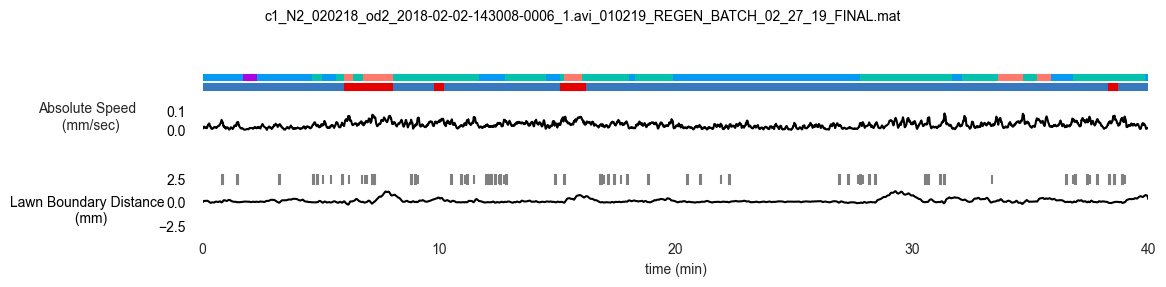

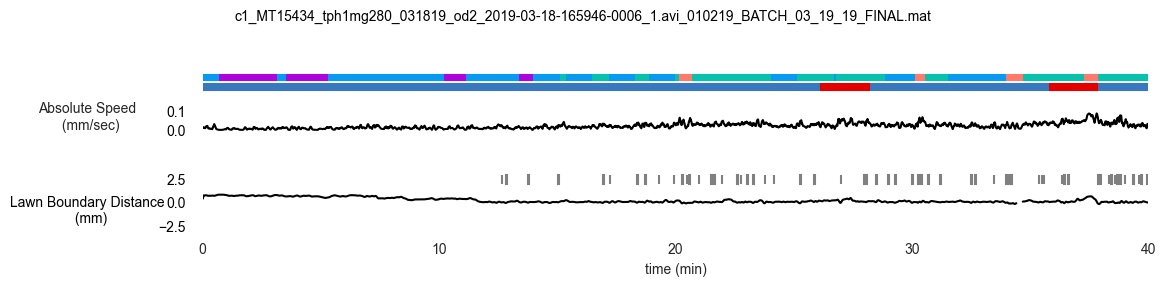

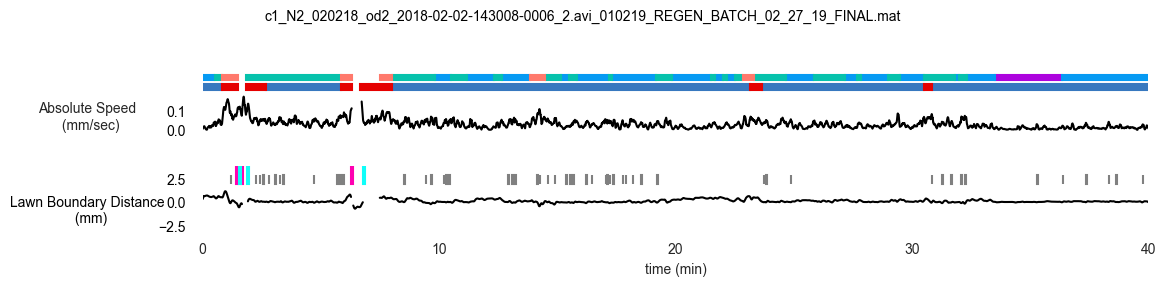

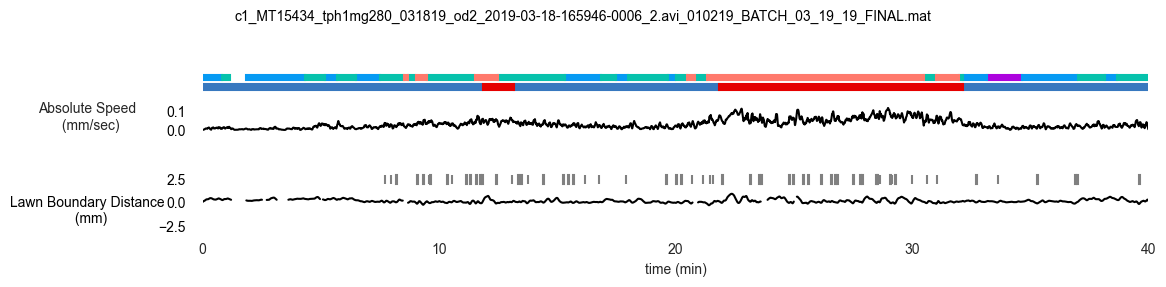

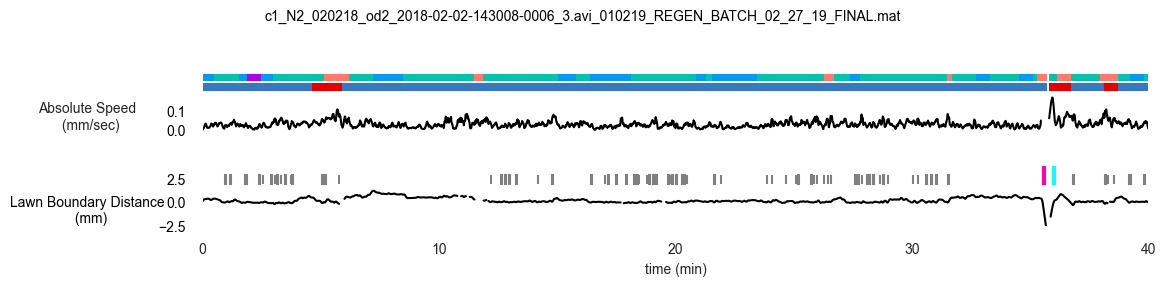

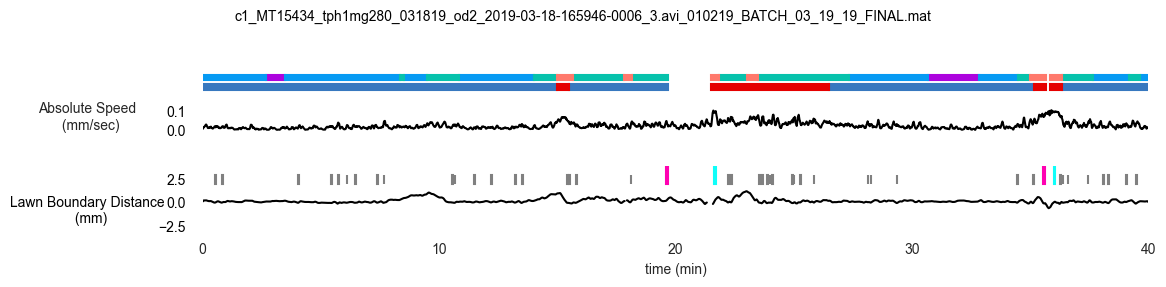

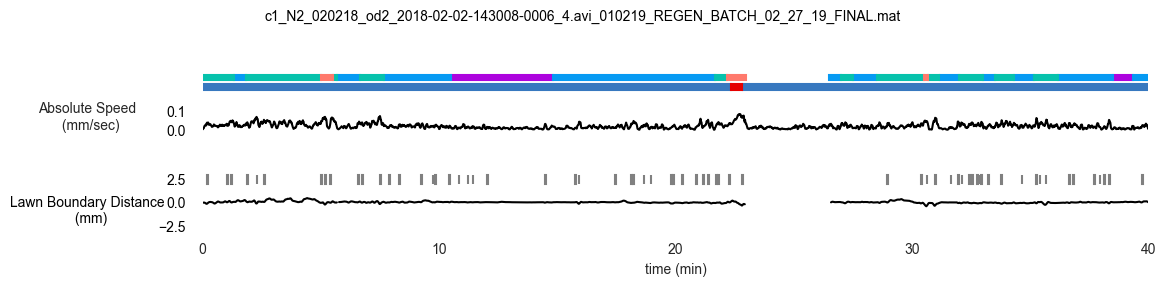

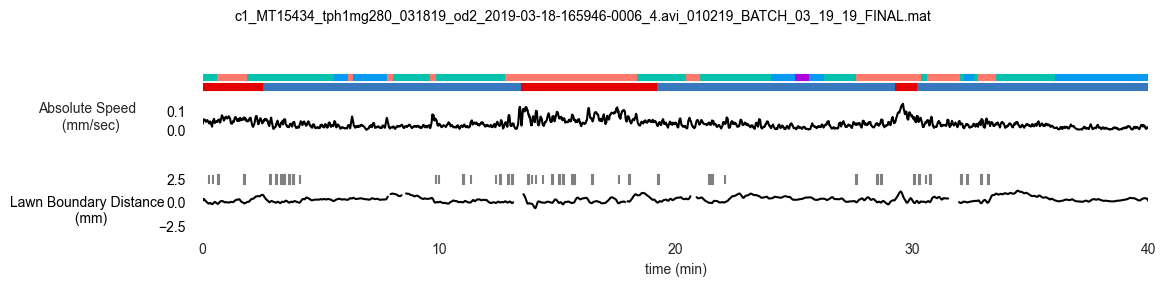

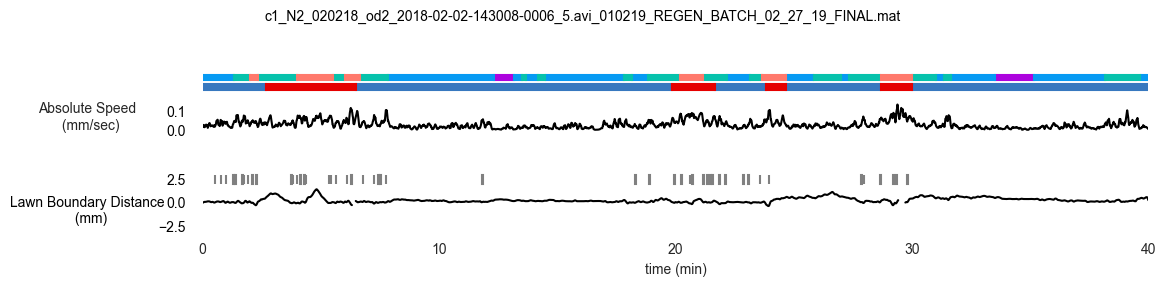

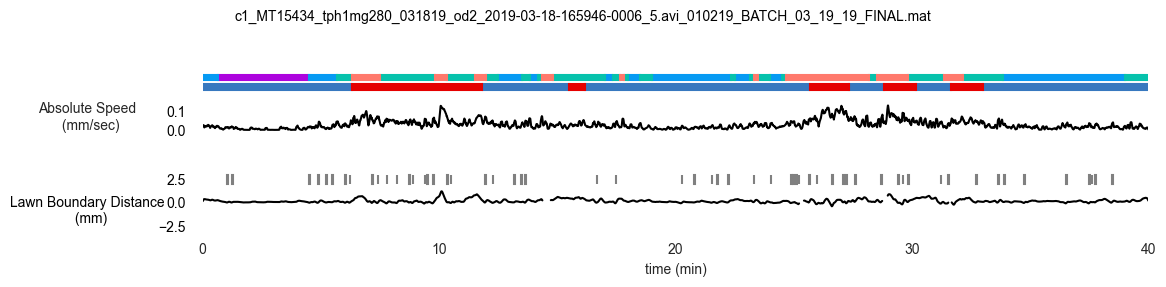

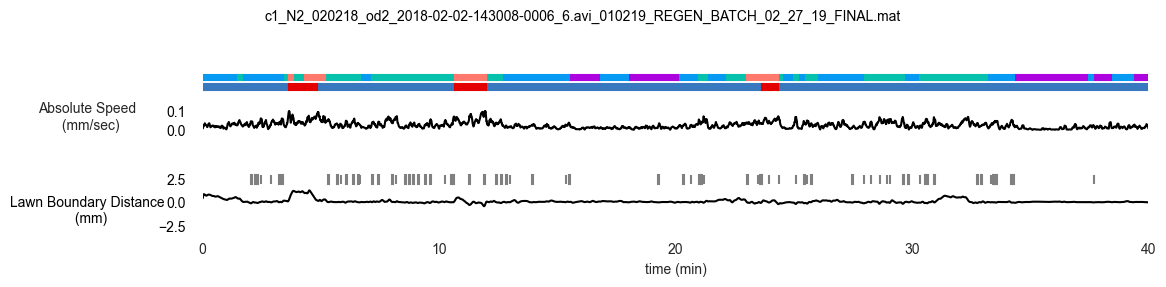

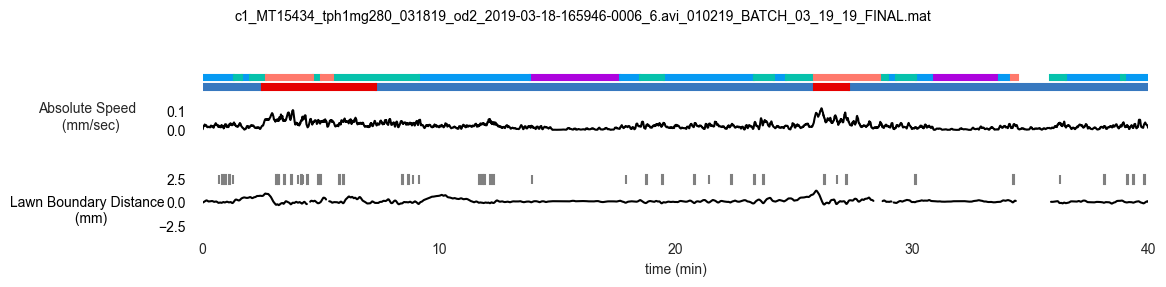

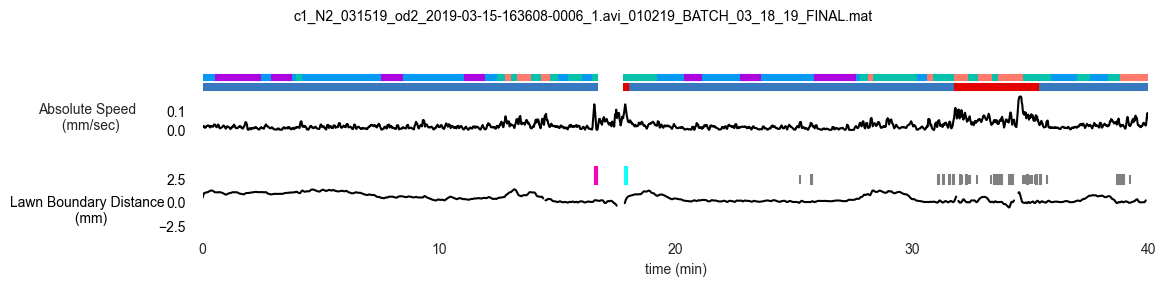

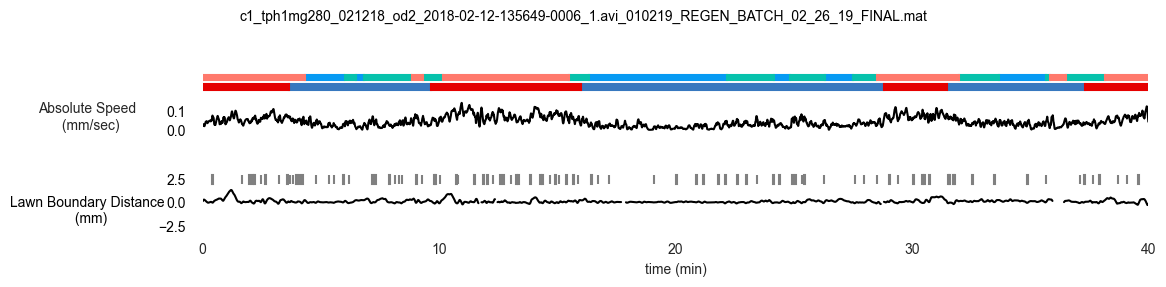

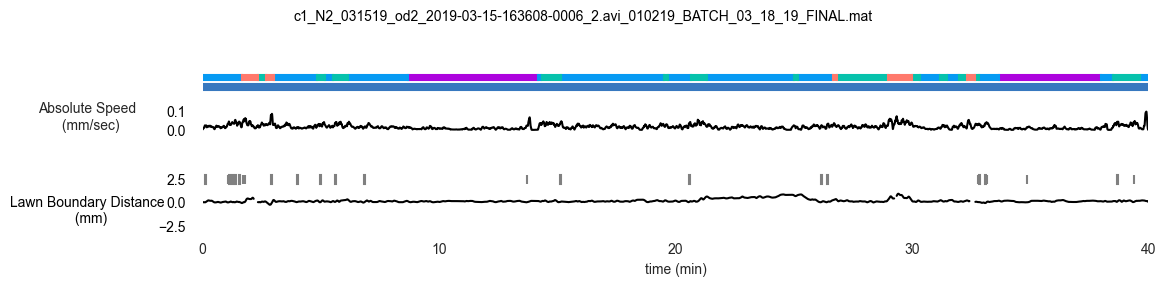

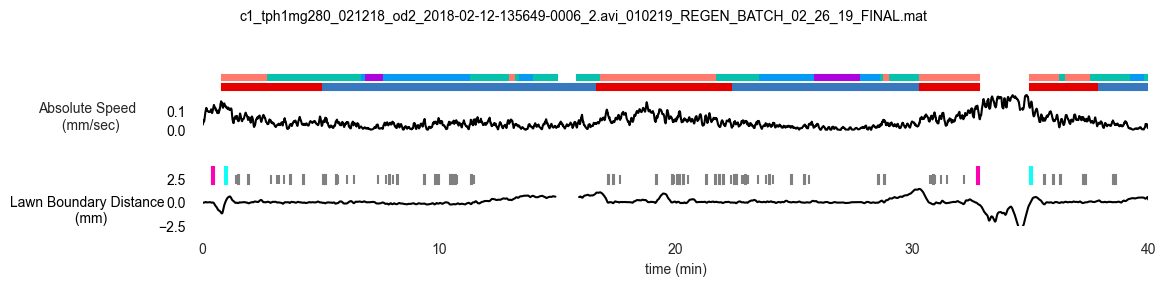

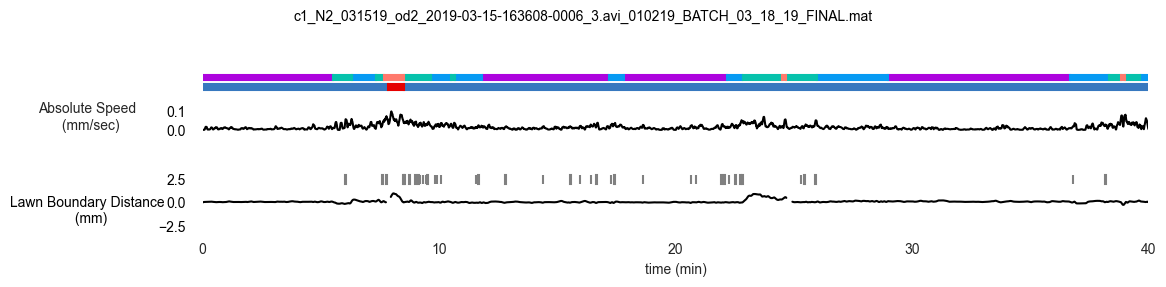

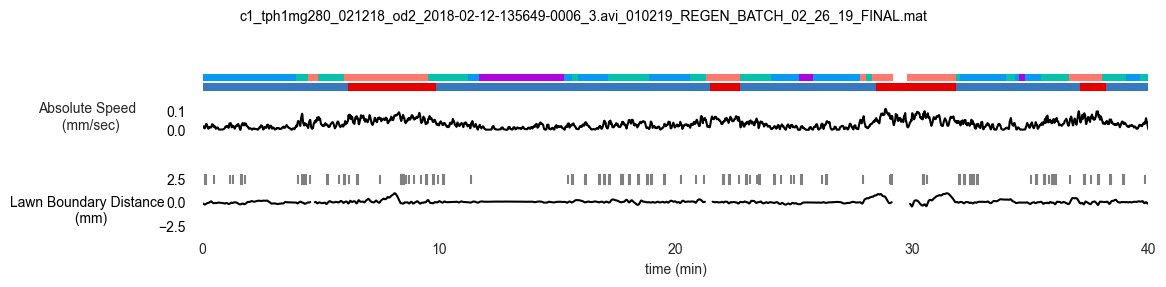

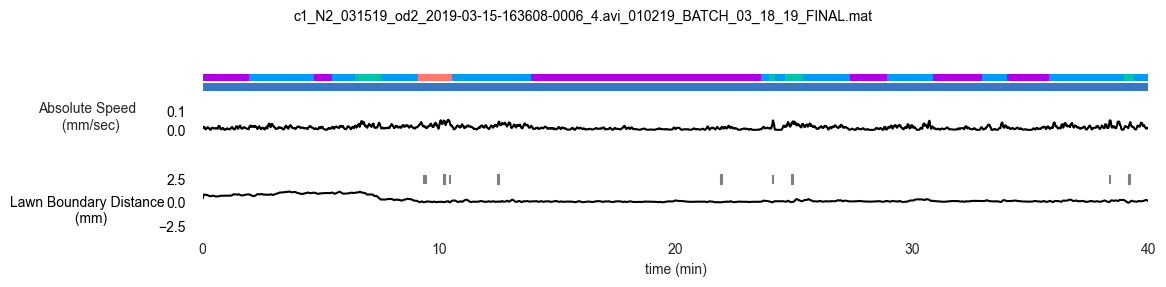

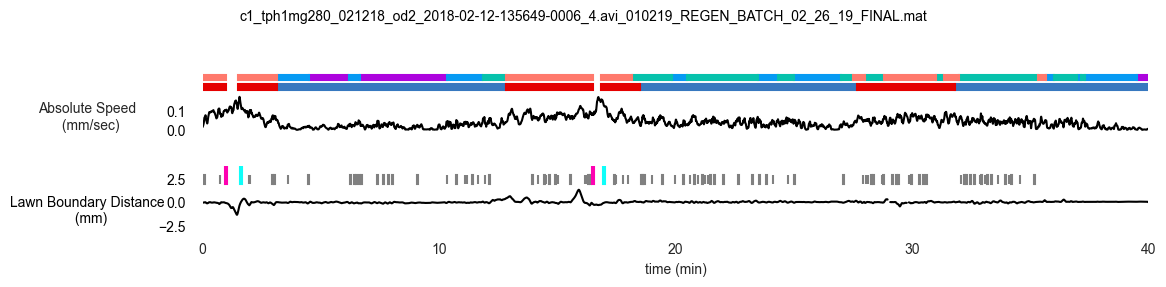

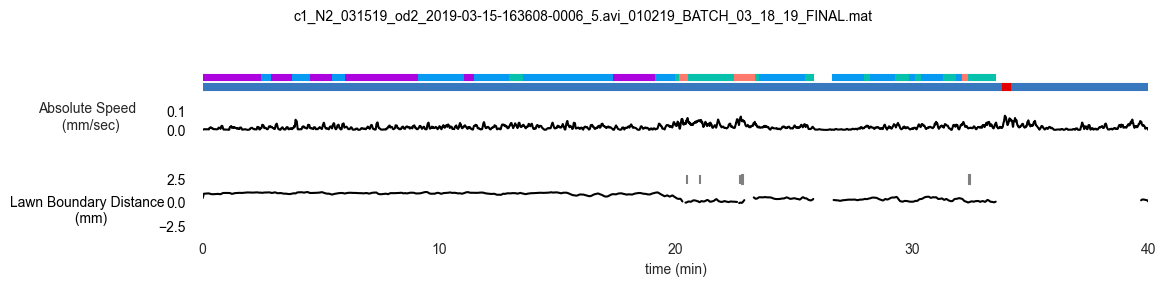

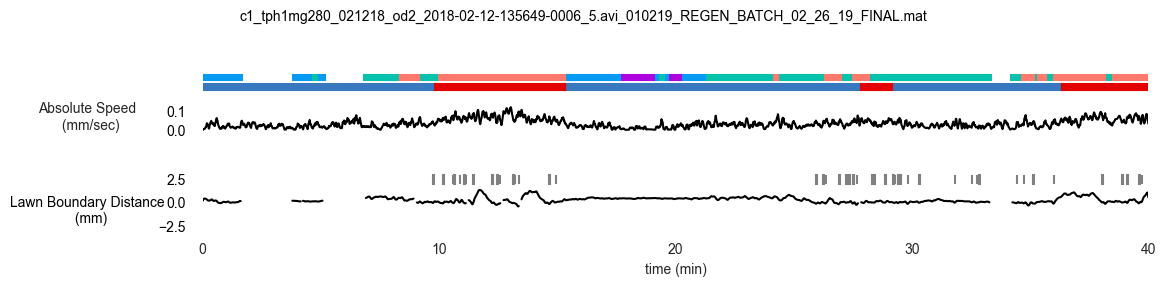

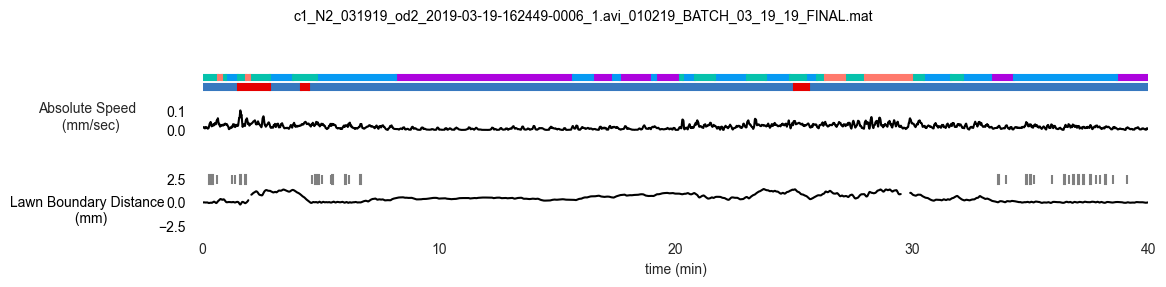

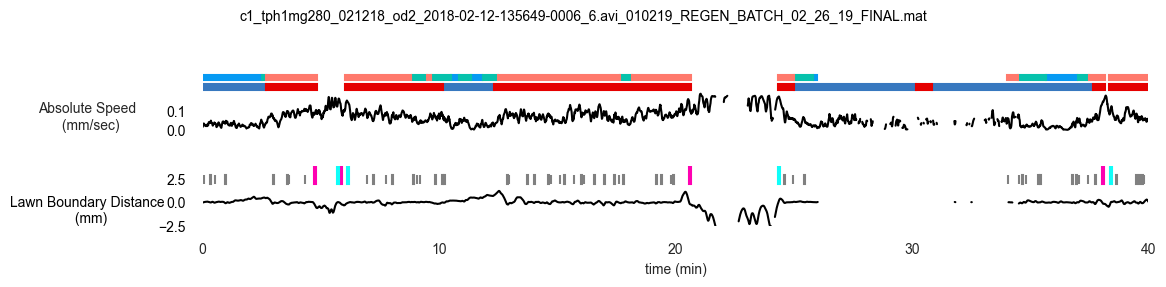

In [69]:
#Plot sample traces with RD annotation

#show example track annotations of roaming and dwelling in UL and LL data
from matplotlib.patches import Rectangle

timeLine = np.linspace(0,40,7200)
xtickSpots = np.linspace(0,len(timeLine-1),5).astype(int)
xtickSpots[-1] = xtickSpots[-1]-1
xtickLabels = np.round(timeLine[xtickSpots]).astype(int).astype(str)

#make a subfolder to save these figures
separator = ','
genNames = separator.join(genotypes)
folderName = 'single traces (state annotations)'
sub_subfolder = os.path.join(subfolder,folderName)
if not os.path.exists(sub_subfolder):
    os.makedirs(sub_subfolder)

# randomIdx = np.random.choice(np.arange(len(Data['matfilename'])),20,replace=False)
# for idx in range(Data['Centroid_speed'].shape[0]):
randomIdx = np.arange(12)
for idx in randomIdx:
    for Data in Data_subs.values():
        ################ Start with Centroid-related measurements
        Speed_midbody = movMean(abs(Data['Midbody_speed'][idx]),15)
        AngSpeed_midbody = (Data['Midbody_angspeed'][idx])
        RD_midbody = Data['RD_states_Matrix_exog'][idx].astype(int).filled(25).reshape(1,-1)
        RD_midbody = np.repeat(RD_midbody,binSize)

        Speed_cent = movMean(abs(Data['Centroid_speed'][idx]),15)
        AngSpeed_cent = (Data['Centroid_angspeed'][idx])
        RD_cent = Data['RD_states_Matrix_exog_Cent'][idx].astype(int).filled(25).reshape(1,-1)
        RD_cent = np.repeat(RD_cent,binSize)

        BacDensity_head = movMean(Data['Bacterial_Density'][idx],15)
        ML = Data['arHMM_MLstates'][idx].astype(int).filled(25).reshape(1,-1)
        ML = np.repeat(ML,binSize)

        fig, axs = plt.subplots(2,1,figsize=(12,3),sharex=True)

        axs[0].set_facecolor('w')
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        axs[0].spines['bottom'].set_visible(False)
        axs[0].spines['left'].set_visible(False)
        
        startIdx = 0
        endIdx = 7200

        #plot RD bouts
        for i in range(RD_hmm_Cent_exog.K):
            stateIntervals = get_intervals(RD_cent==i,0)
            if stateIntervals.size>0:
                intLen = stateIntervals[:,1]-stateIntervals[:,0]
                for intV, intL in zip(stateIntervals,intLen):
                    axs[0].add_patch(Rectangle((intV[0], 0.22), intL, 0.03,edgecolor=colors[i], facecolor=colors[i])) 

        #plot arHMM bouts
        for i in range(arHMM_model.K):
            stateIntervals = get_intervals(ML==i,0)
            if stateIntervals.size>0:
                intLen = stateIntervals[:,1]-stateIntervals[:,0]
                for intV, intL in zip(stateIntervals,intLen):
                    axs[0].add_patch(Rectangle((intV[0], 0.27), intL, 0.03,edgecolor=arhmm_colors[i], facecolor=arhmm_colors[i])) 

        color='black'
        axs[0].grid(b=None)
        axs[0].plot(Speed_cent,color='k',lw=1.5)
        axs[0].set_xlim(0,np.where(~np.isnan(Speed_cent))[0].max())
        axs[0].set_yticks([0,0.1])
        axs[0].set_ylabel('Absolute Speed \n (mm/sec)',fontsize=10,rotation = 0)
        axs[0].yaxis.set_label_coords(-0.12,0.0)
        axs[0].tick_params(axis='y', labelcolor='k', labelsize=10)
   
        if not ('uniform' in genotypes or 'UL' in genotypes):
            LawnBoundDist = movMean(Data['Lawn_Boundary_Dist'][idx],15)
            HeadpokeRev = Data['HeadPokeRev'][idx]
            HeadpokeFwd = Data['HeadPokeFwd'][idx]
            HeadpokePause = Data['HeadPokePause'][idx]
            HeadpokeAll = Data['HeadPokesAll'][idx]
            Lawn_Exit = Data['Lawn_Exit'][idx]
            Lawn_Entry = Data['Lawn_Entry'][idx]
            hprIdx = np.where(HeadpokeAll)[0]
            axs[1].set_facecolor('w')
            color = 'black'

            axs[1].grid(b=None)
            axs[1].spines['top'].set_visible(False)
            axs[1].spines['right'].set_visible(False)
            axs[1].spines['bottom'].set_visible(False)
            axs[1].spines['left'].set_visible(False)
            axs[1].plot(LawnBoundDist, color='k',lw=1.5)
            axs[1].set_ylim([-2.5,4])
            axs[1].tick_params(axis='y', labelcolor='k', labelsize=10)
            axs[1].set_ylabel('Lawn Boundary Distance \n (mm)',color=color, fontsize=10, rotation = 0) # we already handled the x-label with ax1
            axs[1].yaxis.set_label_coords(-0.12,0.0)

            hprIdx = np.where(HeadpokeRev)[0]
            for h in hprIdx:
                axs[1].add_patch(Rectangle((h, 2), 5, 1,edgecolor='gray', facecolor='gray'))
            exitIdx = np.where(Lawn_Exit)[0]
            for e in exitIdx:
                axs[1].add_patch(Rectangle((e, 2), 15, 2,edgecolor=colors[10], facecolor=colors[10])) 
            entryIdx = np.where(Lawn_Entry)[0]
            for e in entryIdx:
                axs[1].add_patch(Rectangle((e, 2), 15, 2,edgecolor=colors[11], facecolor=colors[11]))

            axs[1].set_xlabel('time (min)')
            axs[1].set_xticks(xtickSpots)
            axs[1].set_xticklabels(xtickLabels)

        plt.suptitle(Data['matfilename'].iloc[idx][0],fontsize=10)
        if saveFigures:
            outpath = os.path.join(sub_subfolder,Data['matfilename'].iloc[idx][0][:-4]+'_withRD_narrow''.pdf')
            plt.savefig(outpath)#,dpi=300)